# Model Evaluation Suite

Comprehensive evaluation module for Knowledge vs Reasoning Separation project.

This notebook consolidates all evaluation functionality including:
- **Winograd Schema Challenge** evaluation
- **SQuAD-style QA** evaluation
- **GLUE benchmarks** evaluation
- Error analysis and visualization tools
- Performance analysis and reporting

## 1. Setup and Imports

In [20]:
from typing import List, Dict, Optional, Union, Tuple, Any
from pathlib import Path
from collections import defaultdict, Counter
import json
import time
import math
import random
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

print("All imports successful!")

All imports successful!


## 1.1 Research Framework: Task Quadrants

This section defines the task categorization framework for testing our research question:
**"How does ε-masking affect performance across tasks with different knowledge/reasoning demands?"**

### Task Categorization

Tasks are categorized along two dimensions:
- **Knowledge Demand**: How much external/factual knowledge is required
  - **Light**: Self-contained, minimal world knowledge needed
  - **Medium**: Some context/knowledge helpful but not essential
  - **Heavy**: Requires substantial external knowledge
  
- **Reasoning Demand**: How much logical inference/processing is required
  - **Light**: Simple pattern matching or classification
  - **Medium**: Moderate inference (e.g., span extraction)
  - **Heavy**: Complex reasoning (e.g., coreference, logical deduction)

### Research Hypothesis

**H0**: Tasks with light knowledge demands and heavy reasoning demands (e.g., Winograd)
will show **positive correlation** with epsilon, benefiting from knowledge masking as it
forces the model to rely on reasoning rather than memorized patterns.


In [21]:
# Task Quadrant Mappings
TASK_QUADRANTS = {
    # Format: task_name -> (knowledge_demand, reasoning_demand)
    
    # Winograd-style: Light knowledge (self-contained), Heavy reasoning (coreference)
    "winograd": ("light", "heavy"),
    "winogrande": ("light", "heavy"),
    "winograd_dummy": ("light", "heavy"),
    
    # SQuAD: Heavy knowledge (external context), Medium reasoning (span extraction)
    "squad": ("heavy", "medium"),
    "squad_dummy": ("heavy", "medium"),
    
    # GLUE tasks
    "SST-2": ("light", "light"),      # Sentiment in sentence, simple classification
    "sst-2": ("light", "light"),
    
    "CoLA": ("light", "heavy"),       # Grammatical rules, syntactic judgment
    "cola": ("light", "heavy"),
    
    "MRPC": ("medium", "heavy"),      # Paraphrase requires comparison/inference
    "mrpc": ("medium", "heavy"),
    
    "QQP": ("medium", "heavy"),       # Question paraphrase detection
    "qqp": ("medium", "heavy"),
    
    "RTE": ("medium", "heavy"),       # Textual entailment reasoning
    "rte": ("medium", "heavy"),
    
    "QNLI": ("heavy", "medium"),      # Question answering with NLI
    "qnli": ("heavy", "medium"),
    
    "MNLI": ("medium", "heavy"),      # Multi-genre NLI, complex inference
    "mnli": ("medium", "heavy"),
}

# Quadrant definitions for reference
QUADRANT_DEFINITIONS = {
    ("heavy", "heavy"): {
        "name": "Heavy Knowledge + Heavy Reasoning",
        "description": "Complex QA requiring both substantial knowledge and inference",
        "examples": ["Complex reasoning QA", "Multi-hop reasoning"],
        "hypothesis": "Neutral to negative epsilon correlation (needs both knowledge and reasoning)"
    },
    ("heavy", "medium"): {
        "name": "Heavy Knowledge + Medium Reasoning",
        "description": "Knowledge-intensive tasks with moderate reasoning",
        "examples": ["SQuAD", "QNLI"],
        "hypothesis": "Negative epsilon correlation (masking hurts knowledge retrieval)"
    },
    ("heavy", "light"): {
        "name": "Heavy Knowledge + Light Reasoning",
        "description": "Factual retrieval with minimal inference",
        "examples": ["Fact extraction", "Simple QA"],
        "hypothesis": "Strong negative epsilon correlation (pure knowledge retrieval)"
    },
    ("medium", "heavy"): {
        "name": "Medium Knowledge + Heavy Reasoning",
        "description": "Moderate knowledge with complex reasoning",
        "examples": ["MRPC", "QQP", "RTE", "MNLI"],
        "hypothesis": "Weak positive to neutral epsilon correlation"
    },
    ("medium", "medium"): {
        "name": "Medium Knowledge + Medium Reasoning",
        "description": "Balanced knowledge and reasoning demands",
        "examples": ["Reading comprehension"],
        "hypothesis": "Neutral epsilon correlation"
    },
    ("medium", "light"): {
        "name": "Medium Knowledge + Light Reasoning",
        "description": "Some knowledge, simple classification",
        "examples": ["Named entity classification"],
        "hypothesis": "Slight negative epsilon correlation"
    },
    ("light", "heavy"): {
        "name": "Light Knowledge + Heavy Reasoning",
        "description": "Self-contained reasoning puzzles",
        "examples": ["Winograd", "WinoGrande", "CoLA"],
        "hypothesis": "POSITIVE epsilon correlation (KEY HYPOTHESIS - masking helps reasoning)"
    },
    ("light", "medium"): {
        "name": "Light Knowledge + Medium Reasoning",
        "description": "Simple inference with minimal external knowledge",
        "examples": ["Simple logical inference"],
        "hypothesis": "Weak positive epsilon correlation"
    },
    ("light", "light"): {
        "name": "Light Knowledge + Light Reasoning",
        "description": "Simple pattern matching or classification",
        "examples": ["SST-2 sentiment"],
        "hypothesis": "Neutral to weak negative epsilon correlation"
    },
}

def get_task_quadrant(task_name: str) -> Optional[Tuple[str, str]]:
    """Get the (knowledge, reasoning) quadrant for a task."""
    return TASK_QUADRANTS.get(task_name)

def get_quadrant_info(quadrant: Tuple[str, str]) -> Dict:
    """Get information about a specific quadrant."""
    return QUADRANT_DEFINITIONS.get(quadrant, {})

print("Task Quadrant Framework loaded!")
print(f"Defined {len(TASK_QUADRANTS)} task mappings across {len(QUADRANT_DEFINITIONS)} quadrants")
print(f"\nKey Hypothesis: {QUADRANT_DEFINITIONS[('light', 'heavy')]['hypothesis']}")


Task Quadrant Framework loaded!
Defined 19 task mappings across 9 quadrants

Key Hypothesis: POSITIVE epsilon correlation (KEY HYPOTHESIS - masking helps reasoning)


## 2. Evaluation Utilities

Shared utilities for epsilon masking, option scoring, generation, and metrics.

### 2.1 Enhanced Masking with NER Preservation

Pluggable NER extraction supporting spaCy (accurate) and regex (fallback) methods.
This ensures structural hints are preserved during epsilon masking, as described in the research methodology.


In [22]:
class NERExtractor:
    """
    Pluggable NER extraction supporting spaCy and regex fallback.
    Extracts named entities to preserve as structural hints during masking.
    """
    
    def __init__(self, method: str = "auto"):
        """
        Initialize NER extractor.
        
        Args:
            method: "spacy", "regex", or "auto" (try spaCy, fall back to regex)
        """
        self.method = method
        self.nlp = None
        self.entity_counter = 0
        
        if method in ("spacy", "auto"):
            try:
                import spacy
                self.nlp = spacy.load("en_core_web_sm")
                self.method = "spacy"
            except (ImportError, OSError):
                if method == "spacy":
                    raise RuntimeError("spaCy not available. Install with: pip install spacy && python -m spacy download en_core_web_sm")
                self.method = "regex"
        
        # Regex patterns for common entity types (fallback)
        self._regex_patterns = {
            "PERSON": re.compile(r'\b[A-Z][a-z]+ [A-Z][a-z]+\b'),
            "ORG": re.compile(r'\b(?:Inc\.|Corp\.|Ltd\.|Company|Corporation|University)\b'),
            "GPE": re.compile(r'\b(?:Paris|London|New York|Tokyo|Berlin|Rome|Madrid)\b'),
            "DATE": re.compile(r'\b\d{4}\b|\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\b'),
        }
    
    def reset_counter(self):
        """Reset entity counter for new document."""
        self.entity_counter = 0
    
    def extract_entities(self, text: str) -> Dict[str, Tuple[str, str]]:
        """
        Extract named entities from text.
        
        Args:
            text: Input text
            
        Returns:
            Dict mapping entity_text -> (entity_type, replacement_token)
            Example: {"Paris": ("GPE", "<GPE_0>"), "Eiffel": ("PERSON", "<PERSON_1>")}
        """
        self.reset_counter()
        entities = {}
        
        if self.method == "spacy" and self.nlp:
            doc = self.nlp(text)
            for ent in doc.ents:
                if ent.text not in entities:
                    entity_type = ent.label_
                    replacement = f"<{entity_type}_{self.entity_counter}>"
                    entities[ent.text] = (entity_type, replacement)
                    self.entity_counter += 1
        else:
            # Regex fallback
            for entity_type, pattern in self._regex_patterns.items():
                for match in pattern.finditer(text):
                    entity_text = match.group()
                    if entity_text not in entities:
                        replacement = f"<{entity_type}_{self.entity_counter}>"
                        entities[entity_text] = (entity_type, replacement)
                        self.entity_counter += 1
        
        return entities

def apply_epsilon_masking_with_ner(tokenizer, text: str, epsilon: float, 
                                   seed: Optional[int] = None, 
                                   preserve_ner: bool = True,
                                   ner_method: str = "auto") -> Tuple[str, Dict]:
    """
    Apply epsilon-masking with NER entity preservation.
    
    Args:
        tokenizer: Hugging Face tokenizer
        text: Input text
        epsilon: Masking probability for content words
        seed: Random seed for reproducibility
        preserve_ner: Whether to preserve named entities
        ner_method: "spacy", "regex", or "auto"
        
    Returns:
        Tuple of (masked_text, entity_mapping)
    """
    if epsilon <= 0.0:
        return text, {}
    
    if seed is not None:
        random.seed(seed)
    
    # Extract entities if requested
    entity_mapping = {}
    if preserve_ner:
        ner_extractor = NERExtractor(method=ner_method)
        entity_mapping = ner_extractor.extract_entities(text)
    
    # Replace entities with typed tokens before tokenization
    processed_text = text
    entity_replacements = {}
    for entity_text, (entity_type, replacement) in entity_mapping.items():
        processed_text = processed_text.replace(entity_text, replacement)
        entity_replacements[replacement] = entity_text
    
    # Tokenize
    tokens = tokenizer.tokenize(processed_text)
    masked_tokens: List[str] = []
    
    for token in tokens:
        # Check if token is part of an entity replacement
        is_entity = any(repl in token for repl in entity_replacements.keys())
        
        if is_entity or _is_function_word_token(token) or _is_punctuation_token(token):
            masked_tokens.append(token)
        else:
            if random.random() < epsilon:
                mask_token = getattr(tokenizer, "mask_token", None) or "<MASK>"
                masked_tokens.append(mask_token)
            else:
                masked_tokens.append(token)
    
    masked_text = tokenizer.convert_tokens_to_string(masked_tokens)
    return masked_text, entity_mapping

print("NER-aware masking utilities loaded!")
print(f"Available NER methods: spacy (if installed), regex (fallback)")


NER-aware masking utilities loaded!
Available NER methods: spacy (if installed), regex (fallback)


In [23]:
# Punctuation regex and function words set
_PUNCT_RE = re.compile(r"^[\\.,!?;:\-()\[\]{}\'\"…]+$")
_FUNCTION_WORDS = {
    "the","a","an","and","or","but","if","then","else","when","while","for","to","of","in","on","at","by","with","as","is","are","was","were","be","been","being","that","this","those","these","it","its","he","she","they","them","his","her","their","we","you","i","not","no","do","does","did","from","because","so","than","too","very","can","could","should","would","will","may","might"
}

def _is_function_word_token(token: str) -> bool:
    clean_token = token.replace("##", "").replace("Ġ", "")
    clean = re.sub(r"[^a-z]", "", clean_token.lower())
    return clean in _FUNCTION_WORDS

def _is_punctuation_token(token: str) -> bool:
    clean_token = token.replace("##", "").replace("Ġ", "")
    return bool(_PUNCT_RE.match(clean_token))

def apply_epsilon_masking(tokenizer, text: str, epsilon: float, seed: Optional[int] = None, 
                         preserve_ner: bool = True, ner_method: str = "auto") -> str:
    """
    Apply epsilon-masking using the given tokenizer with optional NER preservation.
    
    This is a convenience wrapper around apply_epsilon_masking_with_ner that returns only the masked text.
    For backward compatibility, NER preservation is enabled by default.
    """
    masked_text, _ = apply_epsilon_masking_with_ner(tokenizer, text, epsilon, seed, preserve_ner, ner_method)
    return masked_text

@torch.no_grad()
def score_option(tokenizer, model, device: str, prompt: str, option: str) -> Tuple[float, float, int]:
    """Compute total and average log-probability for `option` given `prompt`."""
    prompt_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    full_text = f"{prompt} {option}" if len(prompt) > 0 else option
    full = tokenizer(full_text, return_tensors="pt", add_special_tokens=False)
    input_ids = full.input_ids.to(device)

    outputs = model(input_ids=input_ids)
    logits = outputs.logits
    log_probs = F.log_softmax(logits[:, :-1, :], dim=-1)
    labels = input_ids[:, 1:]

    prompt_len = prompt_ids.size(1)
    total_len = input_ids.size(1)
    option_len = max(total_len - prompt_len, 0)
    if option_len == 0:
        return float("-inf"), float("-inf"), 0

    start = max(prompt_len - 1, 0)
    end = total_len - 1
    rng = torch.arange(start, end, device=device)
    option_token_log_probs = log_probs[0, rng, labels[0, rng]]

    total_logprob = option_token_log_probs.sum().item()
    avg_logprob = (total_logprob / float(option_len)) if option_len > 0 else float("-inf")
    return total_logprob, avg_logprob, int(option_len)

@torch.no_grad()
def greedy_generate(tokenizer, model, device: str, prompt: str, max_new_tokens: int = 32, stop_at_newline: bool = True) -> str:
    """Greedy generation of up to `max_new_tokens` following the prompt."""
    if tokenizer.pad_token is None and tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token

    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).to(device)
    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    generated_ids = output_ids[0][inputs.input_ids.size(1):]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    if stop_at_newline:
        nl_idx = generated_text.find("\n")
        if nl_idx >= 0:
            generated_text = generated_text[:nl_idx]
    return generated_text.strip()

print("Evaluation utilities loaded!")

Evaluation utilities loaded!


In [24]:
# SQuAD metrics
_ARTICLES = {"a", "an", "the"}
_NON_ALNUM_RE = re.compile(r"[^a-z0-9 ]+")

def _normalize_answer(s: str) -> str:
    s = s.lower()
    s = _NON_ALNUM_RE.sub(" ", s)
    s = " ".join(tok for tok in s.split() if tok not in _ARTICLES)
    return s.strip()

def squad_em_f1(prediction: str, ground_truths: List[str]) -> Tuple[float, float]:
    """Calculate Exact Match and F1 for SQuAD-style QA."""
    if not ground_truths:
        return 0.0, 0.0
    pred = _normalize_answer(prediction)

    def f1_score(a_pred: str, a_true: str) -> float:
        pred_tokens = a_pred.split()
        true_tokens = _normalize_answer(a_true).split()
        common = {}
        for t in pred_tokens:
            common[t] = min(common.get(t, 0) + (t in true_tokens), 1)
        num_same = sum(common.values())
        if len(pred_tokens) == 0 or len(true_tokens) == 0:
            return float(pred_tokens == true_tokens)
        if num_same == 0:
            return 0.0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(true_tokens)
        return 2 * precision * recall / (precision + recall)

    em = 0.0
    best_f1 = 0.0
    for gt in ground_truths:
        em = max(em, float(pred == _normalize_answer(gt)))
        best_f1 = max(best_f1, f1_score(pred, gt))
    return em, best_f1

# GLUE metrics
def accuracy(preds: List[str], golds: List[str]) -> float:
    if not preds:
        return 0.0
    correct = sum(1 for p, g in zip(preds, golds) if p == g)
    return correct / len(preds)

def f1_binary(preds: List[str], golds: List[str], positive_label: str) -> float:
    tp = sum(1 for p, g in zip(preds, golds) if p == positive_label and g == positive_label)
    fp = sum(1 for p, g in zip(preds, golds) if p == positive_label and g != positive_label)
    fn = sum(1 for p, g in zip(preds, golds) if p != positive_label and g == positive_label)
    if tp == 0 and fp == 0 and fn == 0:
        return 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def matthews_corrcoef_binary(preds: List[str], golds: List[str], positive_label: str) -> float:
    tp = sum(1 for p, g in zip(preds, golds) if p == positive_label and g == positive_label)
    tn = sum(1 for p, g in zip(preds, golds) if p != positive_label and g != positive_label)
    fp = sum(1 for p, g in zip(preds, golds) if p == positive_label and g != positive_label)
    fn = sum(1 for p, g in zip(preds, golds) if p != positive_label and g == positive_label)
    denom = math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denom == 0:
        return 0.0
    return ((tp * tn) - (fp * fn)) / denom

print("Metrics functions loaded!")

Metrics functions loaded!


## 3. Winograd Schema Evaluator

In [25]:
class WinogradEvaluator:
    """Evaluates models on Winograd Schema Challenge."""
    
    def __init__(self, model_name: str = "gpt2", device: Optional[str] = None):
        self.model_name = model_name
        self.device = device or ('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()

        self._punct_re = re.compile(r"^[\\.,!?;:\-()\[\]{}\'\"…]+$")
        self._function_words = {
            "the","a","an","and","or","but","if","then","else","when","while","for","to","of","in","on","at","by","with","as","is","are","was","were","be","been","being","that","this","those","these","it","its","he","she","they","them","his","her","their","we","you","i","not","no","do","does","did","from","because","so","than","too","very","can","could","should","would","will","may","might"
        }

    def _is_function_word_token(self, token: str) -> bool:
        clean_token = token.replace("##", "").replace("Ġ", "")
        clean = re.sub(r"[^a-z]", "", clean_token.lower())
        return clean in self._function_words

    def _is_punctuation_token(self, token: str) -> bool:
        clean_token = token.replace("##", "").replace("Ġ", "")
        return bool(self._punct_re.match(clean_token))

    def _apply_epsilon_masking(self, text: str, epsilon: float, seed: Optional[int] = None,
                              preserve_ner: bool = True, ner_method: str = "auto") -> str:
        """Apply epsilon masking with optional NER preservation."""
        masked_text, _ = apply_epsilon_masking_with_ner(
            self.tokenizer, text, epsilon, seed, preserve_ner, ner_method
        )
        return masked_text

    @torch.no_grad()
    def _score_option(self, prompt: str, option: str) -> Tuple[float, float, int]:
        prompt_ids = self.tokenizer(prompt, return_tensors="pt", add_special_tokens=False).input_ids.to(self.device)
        full_text = f"{prompt} {option}" if len(prompt) > 0 else option
        full = self.tokenizer(full_text, return_tensors="pt", add_special_tokens=False)
        input_ids = full.input_ids.to(self.device)

        outputs = self.model(input_ids=input_ids)
        logits = outputs.logits
        log_probs = F.log_softmax(logits[:, :-1, :], dim=-1)
        labels = input_ids[:, 1:]

        prompt_len = prompt_ids.size(1)
        total_len = input_ids.size(1)
        option_len = max(total_len - prompt_len, 0)
        if option_len == 0:
            return float("-inf"), float("-inf"), 0

        start = max(prompt_len - 1, 0)
        end = total_len - 1

        rng = torch.arange(start, end, device=self.device)
        option_token_log_probs = log_probs[0, rng, labels[0, rng]]

        total_logprob = option_token_log_probs.sum().item()
        avg_logprob = (total_logprob / float(option_len)) if option_len > 0 else float("-inf")
        return total_logprob, avg_logprob, int(option_len)

    def evaluate_schema(self, schema: Dict, epsilon: float = 0.0, seed: Optional[int] = None) -> Dict:
        text = schema.get("text", "")
        question = schema.get("question", "")
        options: List[str] = schema.get("options", [])
        correct_answer = schema.get("answer")

        masked_text = self._apply_epsilon_masking(text, epsilon, seed)
        prompt = f"{masked_text} {question} Answer:"

        option_details = []
        option_scores = []
        for opt in options:
            tot_lp, avg_lp, opt_len = self._score_option(prompt, opt)
            option_details.append({
                "option": opt,
                "total_logprob": tot_lp,
                "avg_logprob": avg_lp,
                "length": opt_len
            })
            option_scores.append(avg_lp)

        predicted_idx = int(np.argmax(option_scores)) if option_scores else -1
        predicted_answer = options[predicted_idx] if 0 <= predicted_idx < len(options) else None
        is_correct = (predicted_answer == correct_answer)

        confidence = math.exp(option_scores[predicted_idx]) if predicted_idx >= 0 else 0.0

        return {
            "schema_id": schema.get("id"),
            "original_text": text,
            "masked_text": masked_text,
            "epsilon": epsilon,
            "question": question,
            "options": options,
            "correct_answer": correct_answer,
            "predicted_answer": predicted_answer,
            "is_correct": bool(is_correct),
            "option_scores": option_scores,
            "option_details": option_details,
            "confidence": confidence,
            "difficulty": schema.get("difficulty"),
            "reasoning": schema.get("reasoning")
        }
    
    def evaluate_all_schemas(self, schemas: List[Dict], epsilon: float = 0.0, seed: Optional[int] = None) -> List[Dict]:
        results: List[Dict] = []
        for i, schema in enumerate(schemas):
            schema_seed = None if seed is None else seed + i
            results.append(self.evaluate_schema(schema, epsilon, schema_seed))
        return results
    
    def get_performance_metrics(self, results: List[Dict]) -> Dict:
        total = len(results)
        correct = sum(1 for r in results if r.get("is_correct"))
        accuracy = (correct / total) if total > 0 else 0.0

        difficulties = {}
        for r in results:
            diff = r.get("difficulty", "unknown")
            d = difficulties.setdefault(diff, {"total": 0, "correct": 0})
            d["total"] += 1
            d["correct"] += 1 if r.get("is_correct") else 0
        acc_by_diff = {k: (v["correct"] / v["total"]) if v["total"] > 0 else 0.0 for k, v in difficulties.items()}

        confidences = [r.get("confidence", 0.0) for r in results]
        avg_conf = float(np.mean(confidences)) if confidences else 0.0
        avg_conf_correct = float(np.mean([r.get("confidence", 0.0) for r in results if r.get("is_correct")])) if total > 0 else 0.0
        avg_conf_errors = float(np.mean([r.get("confidence", 0.0) for r in results if not r.get("is_correct")])) if total > 0 else 0.0

        return {
            "total": total,
            "correct": correct,
            "accuracy": accuracy,
            "accuracy_by_difficulty": acc_by_diff,
            "avg_confidence": avg_conf,
            "avg_confidence_correct": avg_conf_correct,
            "avg_confidence_errors": avg_conf_errors,
        }
    
    def save_results(self, results: Dict, output_path: Union[str, Path]):
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        with output_path.open("w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=2)
    
    def load_results(self, input_path: Union[str, Path]) -> Dict:
        input_path = Path(input_path)
        with input_path.open("r", encoding="utf-8") as f:
            return json.load(f)

print("WinogradEvaluator class loaded!")

WinogradEvaluator class loaded!


In [26]:
class SquadEvaluator:
    """Evaluates models on SQuAD-style QA using simple generation."""

    def __init__(self, model_name: str = "gpt2", device: Optional[str] = None):
        self.model_name = model_name
        self.device = device or ('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.tokenizer.pad_token is None and self.tokenizer.eos_token is not None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()

    def _build_prompt(self, masked_context: str, question: str) -> str:
        return f"Context: {masked_context}\nQuestion: {question}\nAnswer:"

    def evaluate_example(self, example: Dict, epsilon: float = 0.0, seed: Optional[int] = None,
                         max_new_tokens: int = 32) -> Dict:
        context = example.get("context", "")
        question = example.get("question", "")
        answers: List[str] = example.get("answers", [])

        masked_context = apply_epsilon_masking(self.tokenizer, context, epsilon, seed)
        prompt = self._build_prompt(masked_context, question)
        prediction = greedy_generate(self.tokenizer, self.model, self.device, prompt, max_new_tokens=max_new_tokens)

        em, f1 = squad_em_f1(prediction, answers)

        return {
            "id": example.get("id"),
            "epsilon": epsilon,
            "context": context,
            "masked_context": masked_context,
            "question": question,
            "answers": answers,
            "prediction": prediction,
            "em": float(em),
            "f1": float(f1),
            "title": example.get("title")
        }

    def evaluate_all(self, examples: List[Dict], epsilon: float = 0.0, seed: Optional[int] = None,
                     max_new_tokens: int = 32) -> List[Dict]:
        results: List[Dict] = []
        for i, ex in enumerate(examples):
            per_seed = None if seed is None else seed + i
            results.append(self.evaluate_example(ex, epsilon, per_seed, max_new_tokens))
        return results

    def get_performance_metrics(self, results: List[Dict]) -> Dict:
        total = len(results)
        if total == 0:
            return {"total": 0, "em": 0.0, "f1": 0.0, "avg_pred_len": 0.0}
        ems = [r.get("em", 0.0) for r in results]
        f1s = [r.get("f1", 0.0) for r in results]
        pred_lens = [len(str(r.get("prediction", "")).split()) for r in results]
        return {
            "total": total,
            "em": float(np.mean(ems)) if ems else 0.0,
            "f1": float(np.mean(f1s)) if f1s else 0.0,
            "avg_pred_len": float(np.mean(pred_lens)) if pred_lens else 0.0,
        }

print("SquadEvaluator class loaded!")

SquadEvaluator class loaded!


## 5. GLUE Evaluator

In [27]:
GLUE_LABELS = {
    "SST-2": ["positive", "negative"],
    "CoLA": ["acceptable", "unacceptable"],
    "MRPC": ["paraphrase", "not paraphrase"],
    "QQP": ["paraphrase", "not paraphrase"],
    "RTE": ["entailment", "not entailment"],
    "QNLI": ["entailment", "not entailment"],
    "MNLI": ["entailment", "neutral", "contradiction"],
}

class GlueEvaluator:
    def __init__(self, model_name: str = "gpt2", device: Optional[str] = None):
        self.model_name = model_name
        self.device = device or ('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.tokenizer.pad_token is None and self.tokenizer.eos_token is not None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()

    def _prompt_sst2(self, sentence: str) -> str:
        return f"Task: sentiment classification.\nSentence: {sentence}\nOptions: positive, negative.\nAnswer:"

    def _prompt_cola(self, sentence: str) -> str:
        return f"Task: linguistic acceptability.\nSentence: {sentence}\nOptions: acceptable, unacceptable.\nAnswer:"

    def _prompt_pair(self, task: str, s1: str, s2: str) -> str:
        if task in ("MRPC", "QQP"):
            return (
                f"Task: paraphrase detection.\n"
                f"Sentence1: {s1}\nSentence2: {s2}\n"
                f"Options: paraphrase, not paraphrase.\nAnswer:"
            )
        if task in ("RTE", "QNLI"):
            return (
                f"Task: natural language inference.\n"
                f"Premise: {s1}\nHypothesis: {s2}\n"
                f"Options: entailment, not entailment.\nAnswer:"
            )
        if task == "MNLI":
            return (
                f"Task: natural language inference.\n"
                f"Premise: {s1}\nHypothesis: {s2}\n"
                f"Options: entailment, neutral, contradiction.\nAnswer:"
            )
        raise ValueError(f"Unsupported pairwise task: {task}")

    def _mask_text(self, text: str, epsilon: float, seed: Optional[int]) -> str:
        return apply_epsilon_masking(self.tokenizer, text, epsilon, seed)

    def evaluate_example(self, task: str, example: Dict, epsilon: float = 0.0, seed: Optional[int] = None) -> Dict:
        labels = GLUE_LABELS.get(task)
        if not labels:
            raise ValueError(f"Unsupported GLUE task: {task}")

        if task in ("SST-2", "CoLA"):
            sent = example.get("sentence", "")
            m_sent = self._mask_text(sent, epsilon, seed)
            prompt = self._prompt_sst2(m_sent) if task == "SST-2" else self._prompt_cola(m_sent)
        elif task in ("MRPC", "QQP"):
            s1 = example.get("sentence1", "")
            s2 = example.get("sentence2", "")
            m1 = self._mask_text(s1, epsilon, seed)
            m2 = self._mask_text(s2, epsilon, None if seed is None else seed + 1)
            prompt = self._prompt_pair(task, m1, m2)
        elif task in ("RTE", "QNLI", "MNLI"):
            premise = example.get("premise", "")
            hypothesis = example.get("hypothesis", "")
            mp = self._mask_text(premise, epsilon, seed)
            mh = self._mask_text(hypothesis, epsilon, None if seed is None else seed + 1)
            prompt = self._prompt_pair(task, mp, mh)
        else:
            raise ValueError(f"Unsupported task: {task}")

        option_scores: List[float] = []
        for opt in labels:
            _, avg_lp, _ = score_option(self.tokenizer, self.model, self.device, prompt, opt)
            option_scores.append(avg_lp)
        pred_idx = int(np.argmax(option_scores)) if option_scores else -1
        prediction = labels[pred_idx] if 0 <= pred_idx < len(labels) else None

        return {
            "id": example.get("id"),
            "epsilon": epsilon,
            "task": task,
            "label": example.get("label"),
            "prediction": prediction,
            "option_scores": option_scores,
        }

    def evaluate_all(self, task: str, examples: List[Dict], epsilon: float = 0.0, seed: Optional[int] = None) -> List[Dict]:
        results: List[Dict] = []
        for i, ex in enumerate(examples):
            per_seed = None if seed is None else seed + i
            results.append(self.evaluate_example(task, ex, epsilon, per_seed))
        return results

    def get_performance_metrics(self, task: str, results: List[Dict]) -> Dict:
        total = len(results)
        labels = [r.get("label") for r in results]
        preds = [r.get("prediction") for r in results]
        acc = accuracy(preds, labels)

        metrics: Dict[str, float] = {"total": total, "accuracy": acc}
        if task in ("MRPC", "QQP"):
            metrics["f1"] = f1_binary(preds, labels, positive_label="paraphrase")
        if task == "CoLA":
            metrics["mcc"] = matthews_corrcoef_binary(preds, labels, positive_label="acceptable")
        return metrics

print("GlueEvaluator class loaded!")

GlueEvaluator class loaded!


## 6. Benchmark Suite

Comprehensive orchestrator for running multiple benchmarks.

In [28]:
class BenchmarkSuite:
    """Comprehensive benchmark suite for model evaluation."""
    
    def __init__(self, benchmark_dir: Union[str, Path] = "src/evaluation/benchmarks"):
        self.benchmark_dir = Path(benchmark_dir)
        self.benchmark_dir.mkdir(parents=True, exist_ok=True)
        self._ensure_dummy_winograd()
        self._ensure_dummy_squad()
        self._ensure_dummy_glue()
    
    def _ensure_dummy_winograd(self, filename: str = "winograd_dummy.json"):
        """Create a tiny Winograd-like dataset if none exists."""
        path = self.benchmark_dir / filename
        if path.exists():
            return
        samples = [
            {
                "id": "wsc_0001",
                "text": "The trophy doesn't fit into the brown suitcase because it is too large.",
                "question": "What is too large?",
                "options": ["the trophy", "the suitcase"],
                "answer": "the trophy",
                "difficulty": "medium",
                "reasoning": "coreference"
            },
            {
                "id": "wsc_0002",
                "text": "The trophy doesn't fit into the brown suitcase because it is too small.",
                "question": "What is too small?",
                "options": ["the trophy", "the suitcase"],
                "answer": "the suitcase",
                "difficulty": "medium",
                "reasoning": "coreference"
            },
            {
                "id": "wsc_0003",
                "text": "The city councilmen refused the demonstrators a permit because they feared violence.",
                "question": "Who feared violence?",
                "options": ["the city councilmen", "the demonstrators"],
                "answer": "the city councilmen",
                "difficulty": "hard",
                "reasoning": "commonsense"
            },
            {
                "id": "wsc_0004",
                "text": "The city councilmen refused the demonstrators a permit because they advocated violence.",
                "question": "Who advocated violence?",
                "options": ["the city councilmen", "the demonstrators"],
                "answer": "the demonstrators",
                "difficulty": "hard",
                "reasoning": "commonsense"
            }
        ]
        with path.open("w", encoding="utf-8") as f:
            json.dump(samples, f, ensure_ascii=False, indent=2)

    def _ensure_dummy_squad(self, filename: str = "squad_dummy.json"):
        """Create a tiny SQuAD-like dataset if none exists."""
        path = self.benchmark_dir / filename
        if path.exists():
            return
        samples = [
            {
                "id": "squad_0001",
                "context": "Paris is the capital of France.",
                "question": "What is the capital of France?",
                "answers": ["Paris"]
            },
            {
                "id": "squad_0002",
                "context": "The Pacific Ocean is larger than the Atlantic Ocean.",
                "question": "Which ocean is larger than the Atlantic Ocean?",
                "answers": ["the Pacific Ocean", "Pacific Ocean", "Pacific"]
            }
        ]
        with path.open("w", encoding="utf-8") as f:
            json.dump(samples, f, ensure_ascii=False, indent=2)

    def _ensure_dummy_glue(self):
        """Create tiny GLUE-like datasets for supported tasks if none exist."""
        datasets = {
            "sst-2.json": [
                {"id": "sst2_0001", "sentence": "This movie was fantastic!", "label": "positive"},
                {"id": "sst2_0002", "sentence": "The plot was dull and boring.", "label": "negative"},
            ],
            "cola.json": [
                {"id": "cola_0001", "sentence": "The book is on the table.", "label": "acceptable"},
                {"id": "cola_0002", "sentence": "The book is arrived.", "label": "unacceptable"},
            ],
            "mrpc.json": [
                {"id": "mrpc_0001", "sentence1": "A man is playing guitar.", "sentence2": "A person plays a guitar.", "label": "paraphrase"},
                {"id": "mrpc_0002", "sentence1": "A woman is cooking dinner.", "sentence2": "A man is riding a bike.", "label": "not paraphrase"},
            ],
            "qqp.json": [
                {"id": "qqp_0001", "sentence1": "How do I learn Python?", "sentence2": "What is the best way to learn Python?", "label": "paraphrase"},
                {"id": "qqp_0002", "sentence1": "How to bake a cake?", "sentence2": "Where is the nearest gas station?", "label": "not paraphrase"},
            ],
            "rte.json": [
                {"id": "rte_0001", "premise": "All cats have tails.", "hypothesis": "Mittens has a tail.", "label": "entailment"},
                {"id": "rte_0002", "premise": "No birds can swim.", "hypothesis": "Some birds can swim.", "label": "not entailment"},
            ],
            "qnli.json": [
                {"id": "qnli_0001", "premise": "The Eiffel Tower is in Paris.", "hypothesis": "Is the Eiffel Tower in Paris?", "label": "entailment"},
                {"id": "qnli_0002", "premise": "Mount Everest is in Nepal.", "hypothesis": "Is Mount Everest in Africa?", "label": "not entailment"},
            ],
            "mnli.json": [
                {"id": "mnli_0001", "premise": "A boy is running.", "hypothesis": "A child is moving quickly.", "label": "entailment"},
                {"id": "mnli_0002", "premise": "A woman is cooking.", "hypothesis": "No one is in the kitchen.", "label": "contradiction"},
                {"id": "mnli_0003", "premise": "People are sitting in a park.", "hypothesis": "Some people are outside.", "label": "neutral"},
            ]
        }
        for filename, data in datasets.items():
            p = self.benchmark_dir / filename
            if not p.exists():
                with p.open("w", encoding="utf-8") as f:
                    json.dump(data, f, ensure_ascii=False, indent=2)
    
    def _load_json_dataset(self, name: str) -> List[Dict]:
        path = self.benchmark_dir / f"{name}.json"
        if not path.exists():
            raise FileNotFoundError(f"Benchmark dataset not found: {path}")
        with path.open("r", encoding="utf-8") as f:
            return json.load(f)
    
    def run_winograd_benchmark(self, model_path: Union[str, Path], 
                              epsilon_values: List[float],
                              dataset_name: str = "winograd_dummy",
                              seed: Optional[int] = None,
                              schemas: Optional[List[Dict]] = None,
                              device: Optional[str] = None) -> Dict:
        """Run Winograd Schema Challenge benchmark."""
        if schemas is None:
            schemas = self._load_json_dataset(dataset_name)
        evaluator = WinogradEvaluator(model_name=str(model_path), device=device)

        results_by_epsilon: Dict[str, Dict] = {}
        for eps in epsilon_values:
            detailed = evaluator.evaluate_all_schemas(schemas, epsilon=eps, seed=seed)
            metrics = evaluator.get_performance_metrics(detailed)
            results_by_epsilon[str(eps)] = {
                "metrics": metrics,
                "detailed": detailed,
            }

        best_eps = None
        best_acc = -1.0
        for eps_str, res in results_by_epsilon.items():
            acc = res["metrics"].get("accuracy", 0.0)
            if acc > best_acc:
                best_acc = acc
                best_eps = float(eps_str)

        summary = {
            "best_epsilon": best_eps,
            "best_accuracy": best_acc,
            "num_samples": len(schemas)
        }

        return {
            "benchmark": "winograd",
            "dataset": dataset_name,
            "model": str(model_path),
            "epsilon_values": epsilon_values,
            "results_by_epsilon": results_by_epsilon,
            "summary": summary,
            "created_at": int(time.time())
        }
    
    def run_squad_benchmark(self, model_path: Union[str, Path], 
                           epsilon_values: List[float],
                           dataset_name: str = "squad_dummy",
                           seed: Optional[int] = None,
                           max_new_tokens: int = 32,
                           examples: Optional[List[Dict]] = None,
                           device: Optional[str] = None) -> Dict:
        """Run SQuAD-style benchmark using generative answers."""
        if examples is None:
            exs = self._load_json_dataset(dataset_name)
        else:
            exs = examples
        evaluator = SquadEvaluator(model_name=str(model_path), device=device)

        results_by_epsilon: Dict[str, Dict] = {}
        for eps in epsilon_values:
            detailed = evaluator.evaluate_all(exs, epsilon=eps, seed=seed, max_new_tokens=max_new_tokens)
            metrics = evaluator.get_performance_metrics(detailed)
            results_by_epsilon[str(eps)] = {
                "metrics": metrics,
                "detailed": detailed,
            }

        best_eps = None
        best_f1 = -1.0
        for eps_str, res in results_by_epsilon.items():
            f1 = res["metrics"].get("f1", 0.0)
            if f1 > best_f1:
                best_f1 = f1
                best_eps = float(eps_str)

        summary = {
            "best_epsilon": best_eps,
            "best_f1": best_f1,
            "num_samples": len(exs)
        }

        return {
            "benchmark": "squad",
            "dataset": dataset_name,
            "model": str(model_path),
            "epsilon_values": epsilon_values,
            "results_by_epsilon": results_by_epsilon,
            "summary": summary,
            "created_at": int(time.time())
        }
    
    def run_glue_benchmark(self, model_path: Union[str, Path], 
                          tasks: List[str],
                          dataset_names: Optional[Dict[str, str]] = None,
                          epsilon_values: Optional[List[float]] = None,
                          seed: Optional[int] = None,
                          device: Optional[str] = None,
                          hf_examples: Optional[Dict[str, List[Dict]]] = None) -> Dict:
        """Run GLUE-style benchmarks for selected tasks."""
        epsilon_values = epsilon_values or [0.0]
        evaluator = GlueEvaluator(model_name=str(model_path), device=device)

        per_task_results: Dict[str, Dict] = {}
        for task in tasks:
            ds_name = dataset_names.get(task, task.lower()) if dataset_names else task.lower()
            if hf_examples and task in hf_examples:
                examples = hf_examples[task]
            else:
                examples = self._load_json_dataset(ds_name)

            results_by_epsilon: Dict[str, Dict] = {}
            for eps in epsilon_values:
                detailed = evaluator.evaluate_all(task, examples, epsilon=eps, seed=seed)
                metrics = evaluator.get_performance_metrics(task, detailed)
                results_by_epsilon[str(eps)] = {
                    "metrics": metrics,
                    "detailed": detailed,
                }

            best_eps = None
            best_acc = -1.0
            for eps_str, res in results_by_epsilon.items():
                acc = res["metrics"].get("accuracy", 0.0)
                if acc > best_acc:
                    best_acc = acc
                    best_eps = float(eps_str)

            per_task_results[task] = {
                "dataset": ds_name,
                "results_by_epsilon": results_by_epsilon,
                "summary": {
                    "best_epsilon": best_eps,
                    "best_accuracy": best_acc,
                    "num_samples": len(examples)
                }
            }

        task_accs = [info["summary"]["best_accuracy"] for info in per_task_results.values()]
        macro_avg_acc = float(sum(task_accs) / len(task_accs)) if task_accs else 0.0

        return {
            "benchmark": "glue",
            "model": str(model_path),
            "tasks": tasks,
            "epsilon_values": epsilon_values,
            "per_task": per_task_results,
            "summary": {
                "macro_avg_accuracy": macro_avg_acc,
                "num_tasks": len(tasks)
            },
            "created_at": int(time.time())
        }
    
    def save_benchmark_results(self, results: Dict, output_path: Union[str, Path]):
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        with output_path.open("w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=2)
    
    def load_benchmark_results(self, input_path: Union[str, Path]) -> Dict:
        input_path = Path(input_path)
        with input_path.open("r", encoding="utf-8") as f:
            return json.load(f)

print("BenchmarkSuite class loaded!")

BenchmarkSuite class loaded!


In [29]:
class ErrorAnalyzer:
    """Analyzes errors in model evaluation results."""
    
    def __init__(self):
        self._supported_reason_keys = {"coreference", "commonsense", "syntax", "logic", "unknown"}
    
    def analyze_winograd_errors(self, results: List[Dict]) -> Dict:
        """Analyze errors in Winograd Schema evaluation."""
        errors = [r for r in results if not r.get("is_correct")]
        correct = [r for r in results if r.get("is_correct")]

        total = len(results)
        error_count = len(errors)
        correct_count = len(correct)

        errors_by_difficulty: Dict[str, int] = defaultdict(int)
        for e in errors:
            errors_by_difficulty[e.get("difficulty", "unknown")] += 1

        errors_by_reasoning: Dict[str, int] = defaultdict(int)
        for e in errors:
            key = e.get("reasoning", "unknown")
            errors_by_reasoning[key] += 1

        avg_conf_correct = float(np.mean([r.get("confidence", 0.0) for r in correct])) if correct else 0.0
        avg_conf_errors = float(np.mean([r.get("confidence", 0.0) for r in errors])) if errors else 0.0

        top_confident_errors = sorted(errors, key=lambda x: x.get("confidence", 0.0), reverse=True)[:10]

        return {
            "total": total,
            "error_count": error_count,
            "correct_count": correct_count,
            "errors_by_difficulty": dict(errors_by_difficulty),
            "errors_by_reasoning": dict(errors_by_reasoning),
            "avg_confidence_correct": avg_conf_correct,
            "avg_confidence_errors": avg_conf_errors,
            "top_confident_errors": top_confident_errors,
        }
    
    def categorize_errors(self, results: List[Dict]) -> Dict:
        """Categorize errors by type and pattern."""
        errors = [r for r in results if not r.get("is_correct")]
        categories: Dict[str, int] = defaultdict(int)
        for e in errors:
            reason = e.get("reasoning", "unknown")
            categories[reason] += 1
        return dict(categories)
    
    def analyze_confidence_patterns(self, results: List[Dict]) -> Dict:
        """Analyze confidence patterns in predictions."""
        df = pd.DataFrame(results)
        if df.empty:
            return {"avg_confidence": 0.0, "calibration": []}
        df["is_correct_int"] = df["is_correct"].astype(int)
        avg_conf = float(df["confidence"].mean()) if "confidence" in df else 0.0
        bins = np.linspace(0.0, 1.0, 11)
        df["conf_bin"] = pd.cut(df["confidence"], bins=bins, include_lowest=True)
        cal = df.groupby("conf_bin").agg(acc=("is_correct_int", "mean"), count=("is_correct_int", "size")).reset_index()
        calibration = [
            {
                "bin": str(b),
                "midpoint": float(b.mid),
                "accuracy": float(a),
                "count": int(c),
            }
            for b, a, c in zip(cal["conf_bin"], cal["acc"], cal["count"])
        ]
        return {"avg_confidence": avg_conf, "calibration": calibration}
    
    def generate_error_report(self, results: List[Dict], 
                            model_name: str, epsilon: float) -> Dict:
        """Generate comprehensive error report."""
        summary = self.analyze_winograd_errors(results)
        confidence = self.analyze_confidence_patterns(results)
        return {
            "model": model_name,
            "epsilon": epsilon,
            "summary": summary,
            "confidence": confidence,
        }
    
    def get_error_statistics(self, results: List[Dict]) -> Dict:
        """Get statistical summary of errors."""
        total = len(results)
        errors = [r for r in results if not r.get("is_correct")]
        error_rate = (len(errors) / total) if total > 0 else 0.0
        confs = [r.get("confidence", 0.0) for r in results]
        return {
            "total": total,
            "errors": len(errors),
            "error_rate": error_rate,
            "avg_confidence": float(np.mean(confs)) if confs else 0.0,
        }

print("ErrorAnalyzer class loaded!")

ErrorAnalyzer class loaded!


## 8. Result Analyzer

Performance analysis and trend analysis.

In [30]:
class ResultAnalyzer:
    """Analyzes evaluation results and performance metrics."""
    
    def __init__(self):
        pass
    
    def analyze_performance_trends(self, results_by_epsilon: Dict[float, Dict]) -> Dict:
        """Analyze performance trends across epsilon values."""
        if "results_by_epsilon" in results_by_epsilon:
            mapping = results_by_epsilon["results_by_epsilon"]
        else:
            mapping = results_by_epsilon

        eps = sorted([float(e) for e in mapping.keys()])
        
        sample_metrics = None
        for v in mapping.values():
            if isinstance(v, dict) and "metrics" in v:
                sample_metrics = v["metrics"]
                break
        metric_key = None
        if sample_metrics:
            for k in ("accuracy", "f1", "em"):
                if k in sample_metrics:
                    metric_key = k
                    break
        metric_key = metric_key or (list(sample_metrics.keys())[0] if sample_metrics else "accuracy")

        vals = np.array([
            (mapping[str(e)]["metrics"].get(metric_key) if str(e) in mapping else mapping[e]["metrics"].get(metric_key))
            for e in eps
        ])

        corr = float(np.corrcoef(eps, vals)[0, 1]) if len(eps) > 1 else 0.0
        best_idx = int(np.argmax(vals)) if len(vals) > 0 else -1
        best_eps = eps[best_idx] if best_idx >= 0 else None
        best_val = float(vals[best_idx]) if best_idx >= 0 else 0.0

        return {
            "metric": metric_key,
            "epsilon_values": eps,
            "values": vals.tolist(),
            "correlation_epsilon_metric": corr,
            "best_epsilon": best_eps,
            "best_value": best_val,
        }
    
    def calculate_statistical_significance(self, results1: List[float], 
                                         results2: List[float]) -> Dict:
        """Calculate statistical significance between two result sets."""
        if len(results1) < 2 or len(results2) < 2:
            return {"t_test_p": None, "mannwhitney_p": None, "cohen_d": None}
        t_stat, t_p = stats.ttest_ind(results1, results2, equal_var=False)
        u_stat, u_p = stats.mannwhitneyu(results1, results2, alternative="two-sided")
        m1, m2 = np.mean(results1), np.mean(results2)
        s1, s2 = np.std(results1, ddof=1), np.std(results2, ddof=1)
        n1, n2 = len(results1), len(results2)
        sp = np.sqrt(((n1 - 1) * s1 ** 2 + (n2 - 1) * s2 ** 2) / (n1 + n2 - 2)) if (n1 + n2 - 2) > 0 else 0.0
        d = (m1 - m2) / sp if sp > 0 else None
        return {"t_test_p": float(t_p), "mannwhitney_p": float(u_p), "cohen_d": float(d) if d is not None else None}
    
    def generate_performance_summary(self, results: Dict) -> Dict:
        """Generate performance summary statistics."""
        trend = self.analyze_performance_trends(results)
        return {
            "metric": trend.get("metric"),
            "best_epsilon": trend.get("best_epsilon"),
            "best_value": trend.get("best_value"),
            "correlation_epsilon_metric": trend.get("correlation_epsilon_metric"),
        }
    
    def create_performance_report(self, results: Dict, model_name: str) -> Dict:
        """Create comprehensive performance report."""
        summary = self.generate_performance_summary(results)
        return {
            "model": model_name,
            "summary": summary,
        }

print("ResultAnalyzer class loaded!")

ResultAnalyzer class loaded!


## 8.1 Quadrant Analyzer

Analyzes results across task quadrants to test the research hypothesis about knowledge vs reasoning demands.


In [31]:
class QuadrantAnalyzer:
    """
    Analyzes results across task quadrants to test research hypothesis.
    
    Key hypothesis: Light knowledge + heavy reasoning tasks benefit from epsilon masking.
    """
    
    def __init__(self):
        self.task_quadrants = TASK_QUADRANTS
        self.quadrant_definitions = QUADRANT_DEFINITIONS
    
    def aggregate_by_quadrant(self, benchmark_results: Dict[str, Dict]) -> Dict:
        """
        Group benchmark results by (knowledge, reasoning) quadrant.
        
        Args:
            benchmark_results: Dict mapping benchmark_name -> results_dict
                               Each results_dict should have "results_by_epsilon" key
        
        Returns:
            Dict: {(knowledge, reasoning): {epsilon: aggregated_metrics}}
        """
        quadrant_data = defaultdict(lambda: defaultdict(list))
        
        for benchmark_name, results in benchmark_results.items():
            # Get quadrant for this task
            quadrant = self.task_quadrants.get(benchmark_name)
            if not quadrant:
                continue
            
            # Extract results by epsilon
            if "results_by_epsilon" in results:
                results_by_eps = results["results_by_epsilon"]
            else:
                results_by_eps = results
            
            # Aggregate metrics for each epsilon
            for eps_str, eps_data in results_by_eps.items():
                epsilon = float(eps_str)
                metrics = eps_data.get("metrics", {})
                
                # Store the primary metric (accuracy, f1, or em)
                primary_metric = None
                for key in ["accuracy", "f1", "em"]:
                    if key in metrics:
                        primary_metric = metrics[key]
                        break
                
                if primary_metric is not None:
                    quadrant_data[quadrant][epsilon].append(primary_metric)
        
        # Average metrics for each quadrant and epsilon
        aggregated = {}
        for quadrant, eps_data in quadrant_data.items():
            aggregated[quadrant] = {}
            for epsilon, values in eps_data.items():
                aggregated[quadrant][epsilon] = {
                    "mean": float(np.mean(values)),
                    "std": float(np.std(values)),
                    "count": len(values),
                    "values": values
                }
        
        return aggregated
    
    def analyze_epsilon_correlation(self, quadrant_results: Dict) -> Dict:
        """
        Compute correlation between epsilon and performance for each quadrant.
        
        Args:
            quadrant_results: Output from aggregate_by_quadrant()
        
        Returns:
            Dict: {quadrant: {"correlation": r, "p_value": p, "trend": str}}
        """
        correlations = {}
        
        for quadrant, eps_data in quadrant_results.items():
            epsilon_values = sorted(eps_data.keys())
            metric_values = [eps_data[eps]["mean"] for eps in epsilon_values]
            
            if len(epsilon_values) < 2:
                correlations[quadrant] = {
                    "correlation": 0.0,
                    "p_value": 1.0,
                    "trend": "insufficient_data",
                    "epsilon_values": epsilon_values,
                    "metric_values": metric_values
                }
                continue
            
            # Pearson correlation
            r, p = stats.pearsonr(epsilon_values, metric_values)
            
            # Determine trend
            if p < 0.05:
                if r > 0.1:
                    trend = "positive"
                elif r < -0.1:
                    trend = "negative"
                else:
                    trend = "flat"
            else:
                trend = "not_significant"
            
            correlations[quadrant] = {
                "correlation": float(r),
                "p_value": float(p),
                "trend": trend,
                "epsilon_values": epsilon_values,
                "metric_values": metric_values,
                "is_significant": p < 0.05
            }
        
        return correlations
    
    def test_hypothesis(self, correlation_results: Dict) -> Dict:
        """
        Test the research hypothesis: light knowledge + heavy reasoning 
        benefits from epsilon masking.
        
        Args:
            correlation_results: Output from analyze_epsilon_correlation()
        
        Returns:
            Statistical test results and hypothesis verdict
        """
        target_quadrant = ("light", "heavy")
        
        if target_quadrant not in correlation_results:
            return {
                "hypothesis": "Light knowledge + heavy reasoning shows positive epsilon correlation",
                "verdict": "CANNOT_TEST",
                "reason": "No data available for light knowledge + heavy reasoning quadrant"
            }
        
        target_stats = correlation_results[target_quadrant]
        
        # Test 1: Is correlation positive and significant?
        is_positive = target_stats["correlation"] > 0
        is_significant = target_stats["p_value"] < 0.05
        
        # Test 2: Compare to other quadrants
        other_correlations = []
        for quadrant, stats in correlation_results.items():
            if quadrant != target_quadrant:
                other_correlations.append(stats["correlation"])
        
        target_corr = target_stats["correlation"]
        avg_other_corr = float(np.mean(other_correlations)) if other_correlations else 0.0
        
        # Cohen's d for effect size
        if other_correlations:
            pooled_std = float(np.std(other_correlations + [target_corr]))
            cohens_d = (target_corr - avg_other_corr) / pooled_std if pooled_std > 0 else 0.0
        else:
            cohens_d = None
        
        # Verdict
        if is_positive and is_significant and target_corr > avg_other_corr:
            verdict = "SUPPORTED"
            confidence = "strong" if target_stats["p_value"] < 0.01 else "moderate"
        elif is_positive and target_corr > avg_other_corr:
            verdict = "WEAKLY_SUPPORTED"
            confidence = "weak"
        elif is_positive:
            verdict = "INCONCLUSIVE"
            confidence = "insufficient"
        else:
            verdict = "NOT_SUPPORTED"
            confidence = "refuted"
        
        return {
            "hypothesis": "Light knowledge + heavy reasoning shows positive epsilon correlation",
            "verdict": verdict,
            "confidence": confidence,
            "target_quadrant": target_quadrant,
            "target_correlation": target_corr,
            "target_p_value": target_stats["p_value"],
            "is_positive": is_positive,
            "is_significant": is_significant,
            "avg_other_correlation": avg_other_corr,
            "cohens_d": cohens_d,
            "comparison": {
                "target_vs_others": f"{target_corr:.3f} vs {avg_other_corr:.3f}",
                "effect_size": cohens_d
            },
            "interpretation": self._interpret_verdict(verdict, target_stats, avg_other_corr)
        }
    
    def _interpret_verdict(self, verdict: str, target_stats: Dict, avg_other: float) -> str:
        """Generate human-readable interpretation of hypothesis test."""
        r = target_stats["correlation"]
        p = target_stats["p_value"]
        
        if verdict == "SUPPORTED":
            return (f"The hypothesis is SUPPORTED. Light knowledge + heavy reasoning tasks "
                   f"show positive correlation with epsilon (r={r:.3f}, p={p:.3f}), "
                   f"outperforming other quadrants (avg r={avg_other:.3f}). "
                   f"This suggests masking helps reasoning-focused tasks.")
        elif verdict == "WEAKLY_SUPPORTED":
            return (f"The hypothesis is WEAKLY SUPPORTED. Positive trend observed (r={r:.3f}) "
                   f"but lacks statistical significance (p={p:.3f}). "
                   f"More data may strengthen the conclusion.")
        elif verdict == "INCONCLUSIVE":
            return (f"Results are INCONCLUSIVE. While correlation is positive (r={r:.3f}), "
                   f"it does not clearly outperform other quadrants.")
        else:
            return (f"The hypothesis is NOT SUPPORTED. The correlation is not positive "
                   f"(r={r:.3f}, p={p:.3f}), suggesting masking does not benefit "
                   f"reasoning-focused tasks in this evaluation.")
    
    def compare_quadrants(self, correlation_results: Dict) -> pd.DataFrame:
        """
        Create comparison table showing correlation and trends per quadrant.
        
        Args:
            correlation_results: Output from analyze_epsilon_correlation()
        
        Returns:
            DataFrame with quadrant comparison
        """
        rows = []
        for quadrant, stats in correlation_results.items():
            knowledge, reasoning = quadrant
            quadrant_info = self.quadrant_definitions.get(quadrant, {})
            
            rows.append({
                "Knowledge": knowledge,
                "Reasoning": reasoning,
                "Quadrant": quadrant_info.get("name", f"{knowledge}/{reasoning}"),
                "Correlation": stats["correlation"],
                "P-Value": stats["p_value"],
                "Trend": stats["trend"],
                "Significant": "Yes" if stats["is_significant"] else "No",
                "Expected": quadrant_info.get("hypothesis", "N/A")
            })
        
        df = pd.DataFrame(rows)
        
        # Sort by correlation (descending)
        df = df.sort_values("Correlation", ascending=False)
        
        return df
    
    def generate_full_report(self, benchmark_results: Dict[str, Dict]) -> Dict:
        """
        Generate comprehensive analysis report.
        
        Args:
            benchmark_results: Dict mapping benchmark_name -> results_dict
        
        Returns:
            Complete analysis including aggregation, correlations, and hypothesis test
        """
        # Step 1: Aggregate by quadrant
        quadrant_data = self.aggregate_by_quadrant(benchmark_results)
        
        # Step 2: Analyze correlations
        correlations = self.analyze_epsilon_correlation(quadrant_data)
        
        # Step 3: Test hypothesis
        hypothesis_test = self.test_hypothesis(correlations)
        
        # Step 4: Create comparison table
        comparison_df = self.compare_quadrants(correlations)
        
        return {
            "quadrant_data": quadrant_data,
            "correlations": correlations,
            "hypothesis_test": hypothesis_test,
            "comparison_table": comparison_df,
            "summary": {
                "num_quadrants": len(quadrant_data),
                "verdict": hypothesis_test["verdict"],
                "target_correlation": hypothesis_test.get("target_correlation"),
                "interpretation": hypothesis_test.get("interpretation")
            }
        }

print("QuadrantAnalyzer class loaded!")
print("Ready to test research hypothesis!")


QuadrantAnalyzer class loaded!
Ready to test research hypothesis!


## 9. Result Visualizer

Visualization capabilities for evaluation results.

In [32]:
class ResultVisualizer:
    """Creates visualizations for evaluation results."""
    
    def __init__(self, style: str = "seaborn-v0_8", figsize: tuple = (12, 8)):
        self.style = style
        self.figsize = figsize
        try:
            plt.style.use(self.style)
        except Exception:
            plt.style.use("default")
        sns.set_context("talk")
    
    def plot_epsilon_performance(self, results_by_epsilon: Dict[float, Dict], 
                               output_path: Optional[Union[str, Path]] = None):
        """Plot performance vs epsilon values."""
        if "results_by_epsilon" in results_by_epsilon:
            mapping = results_by_epsilon["results_by_epsilon"]
        else:
            mapping = results_by_epsilon

        eps_values = sorted([float(e) for e in mapping.keys()])
        
        first_metrics = None
        for v in mapping.values():
            if isinstance(v, dict) and "metrics" in v:
                first_metrics = v["metrics"]
                break
        metric_key = None
        if first_metrics:
            for k in ("accuracy", "f1", "em"):
                if k in first_metrics:
                    metric_key = k
                    break
        metric_key = metric_key or (list(first_metrics.keys())[0] if first_metrics else "accuracy")

        metric_values = [
            (mapping[str(e)]["metrics"].get(metric_key) if str(e) in mapping else mapping[e]["metrics"].get(metric_key))
            for e in eps_values
        ]

        avg_conf = [
            (mapping[str(e)]["metrics"].get("avg_confidence", 0.0) if str(e) in mapping else mapping[e]["metrics"].get("avg_confidence", 0.0))
            for e in eps_values
        ]

        error_counts = []
        for e in eps_values:
            m = mapping[str(e)]["metrics"] if str(e) in mapping else mapping[e]["metrics"]
            if "total" in m and "correct" in m:
                errors = m["total"] - m["correct"]
            elif "total" in m and "em" in m:
                errors = int(round(m["total"] * (1.0 - float(m["em"]))))
            else:
                errors = 0
            error_counts.append(errors)

        fig, axes = plt.subplots(1, 3, figsize=self.figsize)

        axes[0].plot(eps_values, metric_values, marker="o")
        axes[0].set_title("Performance vs Epsilon")
        axes[0].set_xlabel("Epsilon")
        ylabel = {"accuracy": "Accuracy", "f1": "F1", "em": "EM"}.get(metric_key, metric_key)
        axes[0].set_ylabel(ylabel)
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(eps_values, avg_conf, marker="s", color="#2a9d8f")
        axes[1].set_title("Avg Confidence vs Epsilon")
        axes[1].set_xlabel("Epsilon")
        axes[1].set_ylabel("Avg Confidence")
        axes[1].grid(True, alpha=0.3)

        axes[2].bar([str(e) for e in eps_values], error_counts, color="#e76f51")
        axes[2].set_title("Error Count vs Epsilon")
        axes[2].set_xlabel("Epsilon")
        axes[2].set_ylabel("Errors")
        axes[2].grid(True, axis="y", alpha=0.3)

        plt.tight_layout()
        if output_path:
            fig.savefig(output_path, dpi=300, bbox_inches="tight")
        return fig, axes
    
    def plot_difficulty_analysis(self, results: List[Dict], 
                               output_path: Optional[Union[str, Path]] = None):
        """Plot performance analysis by difficulty."""
        df = pd.DataFrame(results)
        if df.empty:
            raise ValueError("No results provided for difficulty analysis")
        df["difficulty"].fillna("unknown", inplace=True)
        agg = df.groupby("difficulty").agg(
            total=("is_correct", "count"),
            correct=("is_correct", "sum"),
            avg_confidence=("confidence", "mean"),
        ).reset_index()
        agg["accuracy"] = agg["correct"] / agg["total"].replace(0, np.nan)

        fig, axes = plt.subplots(1, 3, figsize=self.figsize)

        sns.barplot(ax=axes[0], data=agg, x="difficulty", y="accuracy", color="#457b9d")
        axes[0].set_title("Accuracy by Difficulty")
        axes[0].set_ylim(0, 1)
        axes[0].grid(True, axis="y", alpha=0.3)

        sns.barplot(ax=axes[1], data=agg, x="difficulty", y="total", color="#e9c46a")
        axes[1].set_title("Count by Difficulty")
        axes[1].grid(True, axis="y", alpha=0.3)

        sns.barplot(ax=axes[2], data=agg, x="difficulty", y="avg_confidence", color="#2a9d8f")
        axes[2].set_title("Avg Confidence by Difficulty")
        axes[2].grid(True, axis="y", alpha=0.3)

        plt.tight_layout()
        if output_path:
            fig.savefig(output_path, dpi=300, bbox_inches="tight")
        return fig, axes
    
    def plot_confidence_analysis(self, results: List[Dict], 
                               output_path: Optional[Union[str, Path]] = None):
        """Plot confidence analysis."""
        df = pd.DataFrame(results)
        if df.empty:
            raise ValueError("No results provided for confidence analysis")
        df["is_correct_int"] = df["is_correct"].astype(int)

        fig, axes = plt.subplots(1, 3, figsize=self.figsize)

        sns.kdeplot(ax=axes[0], data=df, x="confidence", hue="is_correct", common_norm=False, fill=True)
        axes[0].set_title("Confidence Distribution (Correct vs Error)")
        axes[0].set_xlim(0, 1)
        axes[0].grid(True, alpha=0.3)

        jitter = (np.random.rand(len(df)) - 0.5) * 0.05
        axes[1].scatter(df["confidence"], df["is_correct_int"] + jitter, alpha=0.5)
        axes[1].set_title("Confidence vs Correctness")
        axes[1].set_xlabel("Confidence")
        axes[1].set_yticks([0, 1])
        axes[1].set_yticklabels(["Error", "Correct"])
        axes[1].set_xlim(0, 1)
        axes[1].grid(True, alpha=0.3)

        bins = np.linspace(0.0, 1.0, 11)
        df["conf_bin"] = pd.cut(df["confidence"], bins=bins, include_lowest=True)
        cal = df.groupby("conf_bin").agg(acc=("is_correct_int", "mean"), count=("is_correct_int", "size")).reset_index()
        axes[2].plot([b.mid for b in cal["conf_bin"].cat.categories], cal["acc"], marker="o")
        axes[2].plot([0, 1], [0, 1], linestyle="--", color="gray")
        axes[2].set_title("Calibration (Accuracy vs Confidence)")
        axes[2].set_xlabel("Confidence bin midpoint")
        axes[2].set_ylabel("Empirical Accuracy")
        axes[2].set_xlim(0, 1)
        axes[2].set_ylim(0, 1)
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        if output_path:
            fig.savefig(output_path, dpi=300, bbox_inches="tight")
        return fig, axes

print("ResultVisualizer class loaded!")

ResultVisualizer class loaded!


### 9.1 Quadrant Visualization Extensions

Additional visualization methods for quadrant analysis and hypothesis testing.


In [33]:
# Extend ResultVisualizer with quadrant-specific visualizations

def plot_quadrant_comparison(self, quadrant_results: Dict, correlation_results: Dict,
                            output_path: Optional[Union[str, Path]] = None):
    """
    Plot 2x2 or 3x3 grid showing epsilon vs performance for each quadrant.
    Highlights the key hypothesis quadrant (light knowledge + heavy reasoning).
    """
    quadrants = list(quadrant_results.keys())
    n_quadrants = len(quadrants)
    
    # Determine grid size
    if n_quadrants <= 4:
        nrows, ncols = 2, 2
    elif n_quadrants <= 6:
        nrows, ncols = 2, 3
    else:
        nrows, ncols = 3, 3
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = axes.flatten() if n_quadrants > 1 else [axes]
    
    target_quadrant = ("light", "heavy")
    
    for idx, (quadrant, eps_data) in enumerate(sorted(quadrant_results.items())):
        if idx >= len(axes):
            break
        
        ax = axes[idx]
        epsilon_values = sorted(eps_data.keys())
        metric_values = [eps_data[eps]["mean"] for eps in epsilon_values]
        std_values = [eps_data[eps]["std"] for eps in epsilon_values]
        
        # Highlight target quadrant
        color = '#e63946' if quadrant == target_quadrant else '#457b9d'
        linewidth = 3 if quadrant == target_quadrant else 2
        marker_size = 10 if quadrant == target_quadrant else 8
        
        # Plot with error bars
        ax.errorbar(epsilon_values, metric_values, yerr=std_values,
                   marker='o', linewidth=linewidth, markersize=marker_size,
                   color=color, capsize=5, capthick=2)
        
        knowledge, reasoning = quadrant
        quadrant_info = QUADRANT_DEFINITIONS.get(quadrant, {})
        title = quadrant_info.get("name", f"{knowledge}/{reasoning}")
        
        # Add correlation info
        corr_info = correlation_results.get(quadrant, {})
        r = corr_info.get("correlation", 0.0)
        p = corr_info.get("p_value", 1.0)
        trend = corr_info.get("trend", "")
        
        title += f"\nr={r:.3f}, p={p:.3f}"
        if quadrant == target_quadrant:
            title = "★ " + title + " ★"
        
        ax.set_title(title, fontsize=10, fontweight='bold' if quadrant == target_quadrant else 'normal')
        ax.set_xlabel('Epsilon (Masking Rate)')
        ax.set_ylabel('Performance')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
    
    # Hide empty subplots
    for idx in range(n_quadrants, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle('Performance vs Epsilon by Task Quadrant', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    
    return fig, axes

def plot_epsilon_sensitivity(self, quadrant_results: Dict, correlation_results: Dict,
                            output_path: Optional[Union[str, Path]] = None):
    """
    Line plot showing all quadrants on same axes to compare epsilon sensitivity.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    target_quadrant = ("light", "heavy")
    
    for quadrant, eps_data in sorted(quadrant_results.items()):
        epsilon_values = sorted(eps_data.keys())
        metric_values = [eps_data[eps]["mean"] for eps in epsilon_values]
        
        knowledge, reasoning = quadrant
        quadrant_info = QUADRANT_DEFINITIONS.get(quadrant, {})
        label = quadrant_info.get("name", f"{knowledge}/{reasoning}")
        
        # Get correlation
        corr = correlation_results.get(quadrant, {}).get("correlation", 0.0)
        label += f" (r={corr:.2f})"
        
        # Style
        if quadrant == target_quadrant:
            linewidth = 3
            marker = 'o'
            markersize = 10
            zorder = 10
            alpha = 1.0
        else:
            linewidth = 2
            marker = 's'
            markersize = 7
            zorder = 5
            alpha = 0.7
        
        ax.plot(epsilon_values, metric_values, marker=marker, linewidth=linewidth,
               markersize=markersize, label=label, alpha=alpha, zorder=zorder)
    
    ax.set_xlabel('Epsilon (Masking Rate)', fontsize=12)
    ax.set_ylabel('Performance (Accuracy/F1/EM)', fontsize=12)
    ax.set_title('Epsilon Sensitivity Across Task Quadrants', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    
    return fig, ax

def plot_hypothesis_heatmap(self, correlation_results: Dict,
                           output_path: Optional[Union[str, Path]] = None):
    """
    Heatmap showing correlation values across knowledge x reasoning dimensions.
    """
    # Organize data into matrix
    knowledge_levels = ["light", "medium", "heavy"]
    reasoning_levels = ["light", "medium", "heavy"]
    
    # Create correlation matrix
    corr_matrix = np.full((len(knowledge_levels), len(reasoning_levels)), np.nan)
    
    for quadrant, stats in correlation_results.items():
        knowledge, reasoning = quadrant
        if knowledge in knowledge_levels and reasoning in reasoning_levels:
            k_idx = knowledge_levels.index(knowledge)
            r_idx = reasoning_levels.index(reasoning)
            corr_matrix[k_idx, r_idx] = stats["correlation"]
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(reasoning_levels)))
    ax.set_yticks(np.arange(len(knowledge_levels)))
    ax.set_xticklabels([r.capitalize() for r in reasoning_levels])
    ax.set_yticklabels([k.capitalize() for k in knowledge_levels])
    
    ax.set_xlabel('Reasoning Demand', fontsize=12, fontweight='bold')
    ax.set_ylabel('Knowledge Demand', fontsize=12, fontweight='bold')
    ax.set_title('Epsilon-Performance Correlation Heatmap\n(Positive = masking helps)',
                fontsize=14, fontweight='bold')
    
    # Add correlation values as text
    for i in range(len(knowledge_levels)):
        for j in range(len(reasoning_levels)):
            if not np.isnan(corr_matrix[i, j]):
                quadrant = (knowledge_levels[i], reasoning_levels[j])
                r = corr_matrix[i, j]
                p = correlation_results[quadrant]["p_value"]
                
                # Format text
                text_str = f"{r:.3f}"
                if p < 0.05:
                    text_str += "*"
                if p < 0.01:
                    text_str += "*"
                
                # Highlight hypothesis quadrant
                if quadrant == ("light", "heavy"):
                    bbox_props = dict(boxstyle='round', facecolor='yellow', alpha=0.5)
                    fontweight = 'bold'
                else:
                    bbox_props = None
                    fontweight = 'normal'
                
                text_color = 'white' if abs(r) > 0.5 else 'black'
                ax.text(j, i, text_str, ha="center", va="center",
                       color=text_color, fontsize=12, fontweight=fontweight,
                       bbox=bbox_props)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Correlation (r)', rotation=270, labelpad=20, fontsize=11)
    
    # Add legend
    legend_text = "* p < 0.05, ** p < 0.01\n★ = Hypothesis quadrant"
    ax.text(1.02, -0.15, legend_text, transform=ax.transAxes,
           fontsize=10, verticalalignment='top')
    
    plt.tight_layout()
    
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    
    return fig, ax

# Add methods to ResultVisualizer class
ResultVisualizer.plot_quadrant_comparison = plot_quadrant_comparison
ResultVisualizer.plot_epsilon_sensitivity = plot_epsilon_sensitivity
ResultVisualizer.plot_hypothesis_heatmap = plot_hypothesis_heatmap

print("Extended visualization methods added to ResultVisualizer!")
print("New methods: plot_quadrant_comparison, plot_epsilon_sensitivity, plot_hypothesis_heatmap")


Extended visualization methods added to ResultVisualizer!
New methods: plot_quadrant_comparison, plot_epsilon_sensitivity, plot_hypothesis_heatmap


### Run Winograd Evaluation

In [34]:
# Initialize benchmark suite
suite = BenchmarkSuite(benchmark_dir="src/evaluation/benchmarks")

# Run Winograd benchmark with multiple epsilon values
results = suite.run_winograd_benchmark(
    model_path="gpt2",
    epsilon_values=[0.0, 0.1, 0.3],
    dataset_name="winograd_dummy",
    seed=42
)

# Print summary
print(json.dumps(results["summary"], indent=2))

{
  "best_epsilon": 0.0,
  "best_accuracy": 0.75,
  "num_samples": 4
}


### Run SQuAD Evaluation

In [35]:
# Run SQuAD benchmark
squad_results = suite.run_squad_benchmark(
    model_path="gpt2",
    epsilon_values=[0.0, 0.2],
    dataset_name="squad_dummy",
    seed=42,
    max_new_tokens=32
)

# Print best F1 score
print(f"Best F1: {squad_results['summary']['best_f1']:.3f}")
print(f"Best epsilon: {squad_results['summary']['best_epsilon']}")

/Users/osadeh/Documents/Github/nlp-3523-final-project/.venv/lib/python3.12/site-packages/transformers/pytorch_utils.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)


Best F1: 0.389
Best epsilon: 0.0


### Run GLUE Evaluation

In [36]:
# Run GLUE benchmarks
glue_results = suite.run_glue_benchmark(
    model_path="gpt2",
    tasks=["SST-2", "MRPC"],
    epsilon_values=[0.0, 0.1],
    seed=42
)

# Print macro average accuracy
print(f"Macro avg accuracy: {glue_results['summary']['macro_avg_accuracy']:.3f}")

Macro avg accuracy: 0.500


### Analyze and Visualize Results

/var/folders/mn/7czszdld7kb157fq99zc_24c0000gr/T/ipykernel_74984/1696639484.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = df.groupby("conf_bin").agg(acc=("is_correct_int", "mean"), count=("is_correct_int", "size")).reset_index()


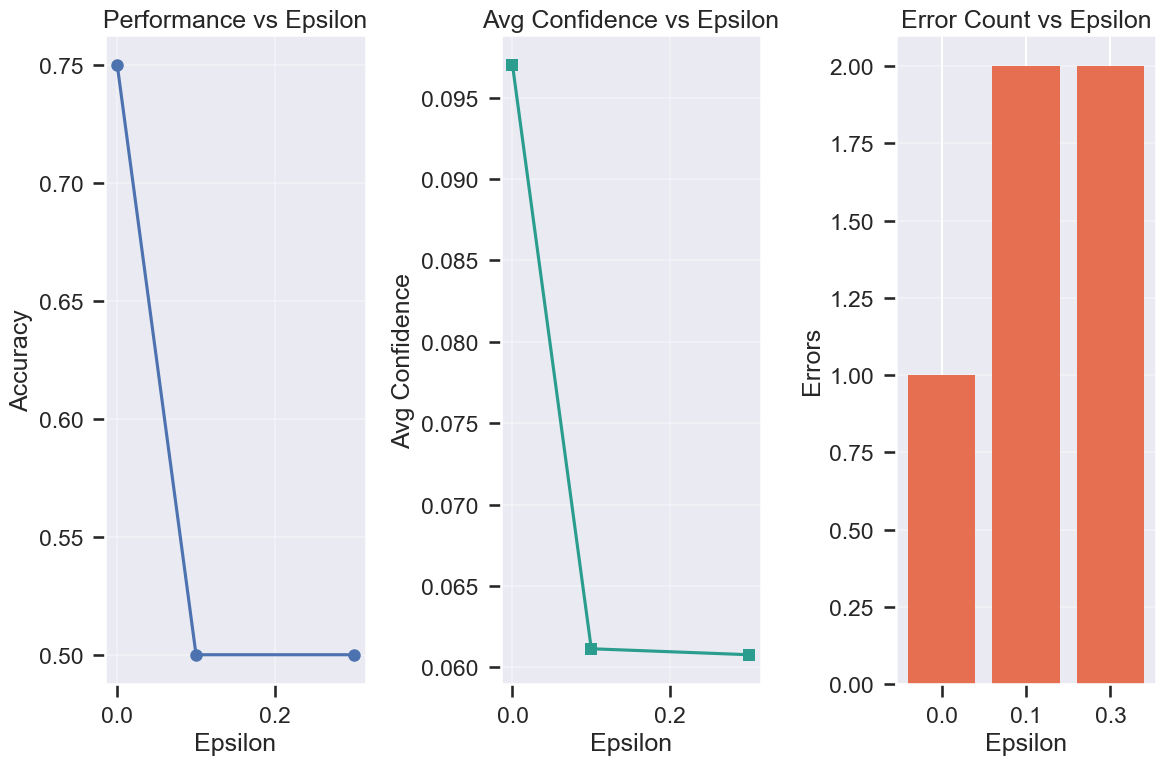

/var/folders/mn/7czszdld7kb157fq99zc_24c0000gr/T/ipykernel_74984/1759792770.py:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["difficulty"].fillna("unknown", inplace=True)


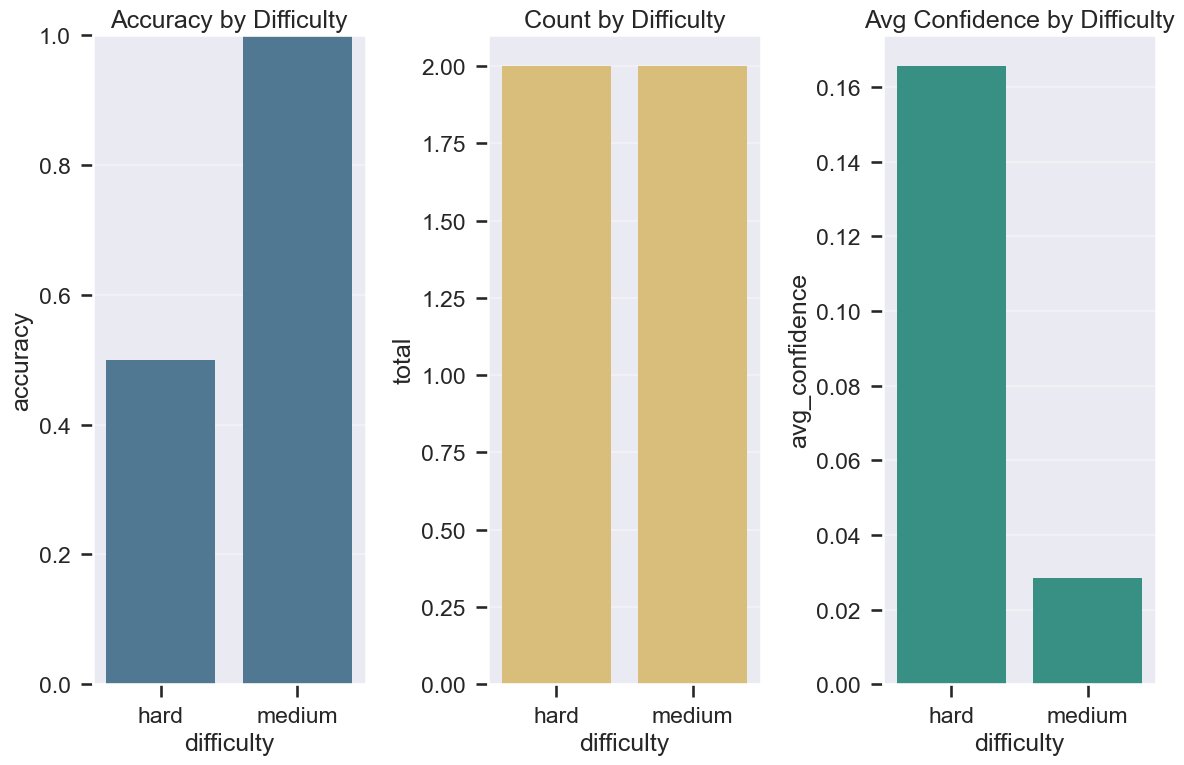

/var/folders/mn/7czszdld7kb157fq99zc_24c0000gr/T/ipykernel_74984/1759792770.py:127: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[0], data=df, x="confidence", hue="is_correct", common_norm=False, fill=True)
/var/folders/mn/7czszdld7kb157fq99zc_24c0000gr/T/ipykernel_74984/1759792770.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = df.groupby("conf_bin").agg(acc=("is_correct_int", "mean"), count=("is_correct_int", "size")).reset_index()


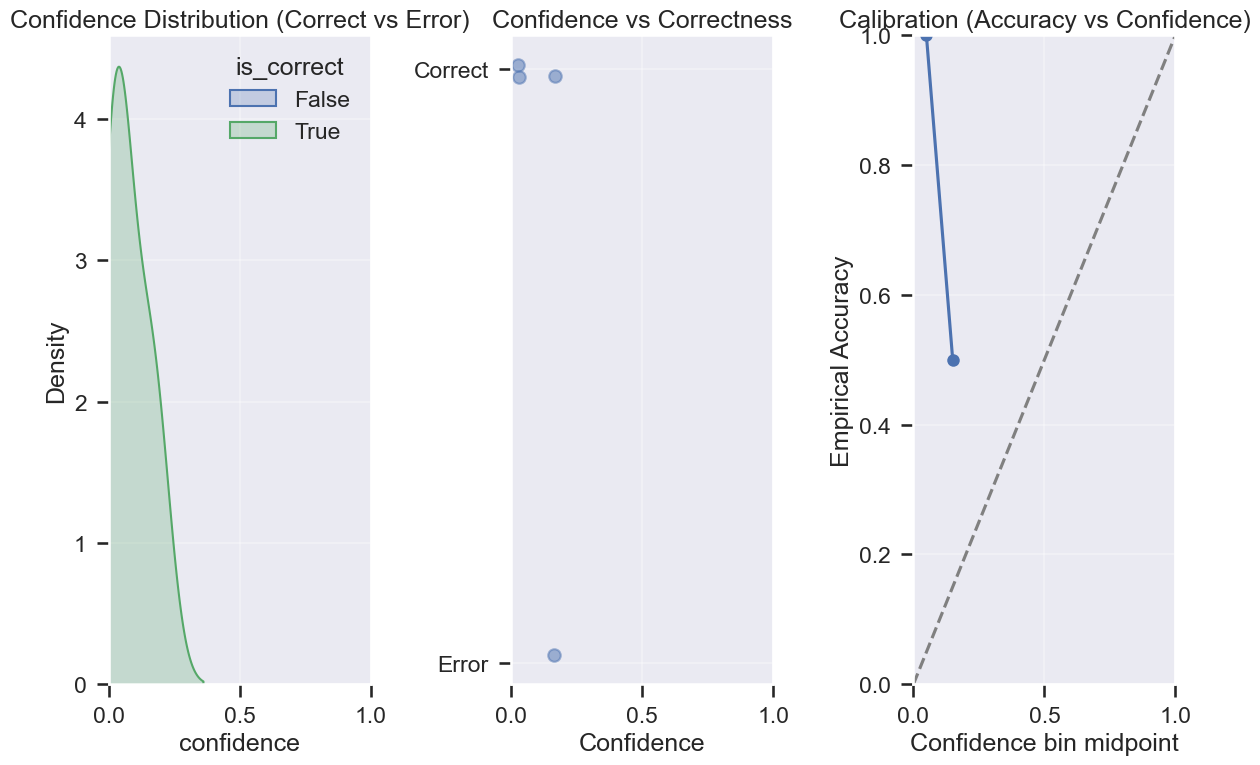

In [37]:
# Initialize analyzers and visualizer
error_analyzer = ErrorAnalyzer()
result_analyzer = ResultAnalyzer()
visualizer = ResultVisualizer()

# Analyze errors
best_eps = results["summary"]["best_epsilon"]
detailed_results = results["results_by_epsilon"][str(best_eps)]["detailed"]
error_report = error_analyzer.generate_error_report(
    detailed_results, 
    model_name="gpt2", 
    epsilon=best_eps
)

# Visualize performance
fig, axes = visualizer.plot_epsilon_performance(results)
plt.show()

# Visualize difficulty analysis
fig, axes = visualizer.plot_difficulty_analysis(detailed_results)
plt.show()

# Visualize confidence analysis
fig, axes = visualizer.plot_confidence_analysis(detailed_results)
plt.show()

### Save and Load Results

In [38]:
# Save results
suite.save_benchmark_results(results, "results/winograd_eval.json")

# Load results
loaded_results = suite.load_benchmark_results("results/winograd_eval.json")

## 11. Direct Evaluator Usage

You can also use individual evaluators directly without the benchmark suite.

In [39]:
# Direct Winograd evaluation
evaluator = WinogradEvaluator(model_name="gpt2")
schema = {
    "id": "test_1",
    "text": "The trophy doesn't fit into the brown suitcase because it is too large.",
    "question": "What is too large?",
    "options": ["the trophy", "the suitcase"],
    "answer": "the trophy",
    "difficulty": "medium",
    "reasoning": "coreference"
}
result = evaluator.evaluate_schema(schema, epsilon=0.1, seed=42)
print(f"Predicted: {result['predicted_answer']}")
print(f"Correct: {result['is_correct']}")
print(f"Confidence: {result['confidence']:.3f}")


Predicted: the suitcase
Correct: False
Confidence: 0.028


## 12. Loading Data from Hugging Face

You can also load datasets directly from Hugging Face.

In [40]:
# Example: Load WinoGrande from Hugging Face
from datasets import load_dataset

ds = load_dataset("winogrande", "winogrande_xs", split="validation")
schemas = []
for i, ex in enumerate(ds):
    options = [ex["option1"], ex["option2"]]
    ans_index = int(ex["answer"]) - 1 if isinstance(ex["answer"], (int, str)) else None
    answer_text = options[ans_index] if ans_index in (0, 1) else None
    schemas.append({
        "id": f"winogrande_xs_{i}",
        "text": ex["sentence"],
        "question": "Which option best completes the sentence?",
        "options": options,
        "answer": answer_text,
        "difficulty": None,
        "reasoning": "commonsense",
    })

# Run evaluation with these schemas
results = suite.run_winograd_benchmark(
    model_path="gpt2",
    epsilon_values=[0.0, 0.1],
    dataset_name="winogrande_xs",
    schemas=schemas,
    seed=42
)

### WinoGrande Results Analysis

Comprehensive presentation of the WinoGrande evaluation results.


WINOGRANDE EVALUATION SUMMARY

Model: gpt2
Dataset: winogrande_xs
Total Samples: 1267

Best Performance:
  - Epsilon: 0.0
  - Accuracy: 50.20%

--------------------------------------------------------------------------------
PERFORMANCE BY EPSILON VALUE
--------------------------------------------------------------------------------
 Epsilon Accuracy  Correct  Total Avg Confidence Conf (Correct) Conf (Errors)
     0.0   50.20%      636   1267         0.0194         0.0193        0.0195
     0.1   50.04%      634   1267         0.0167         0.0174        0.0160


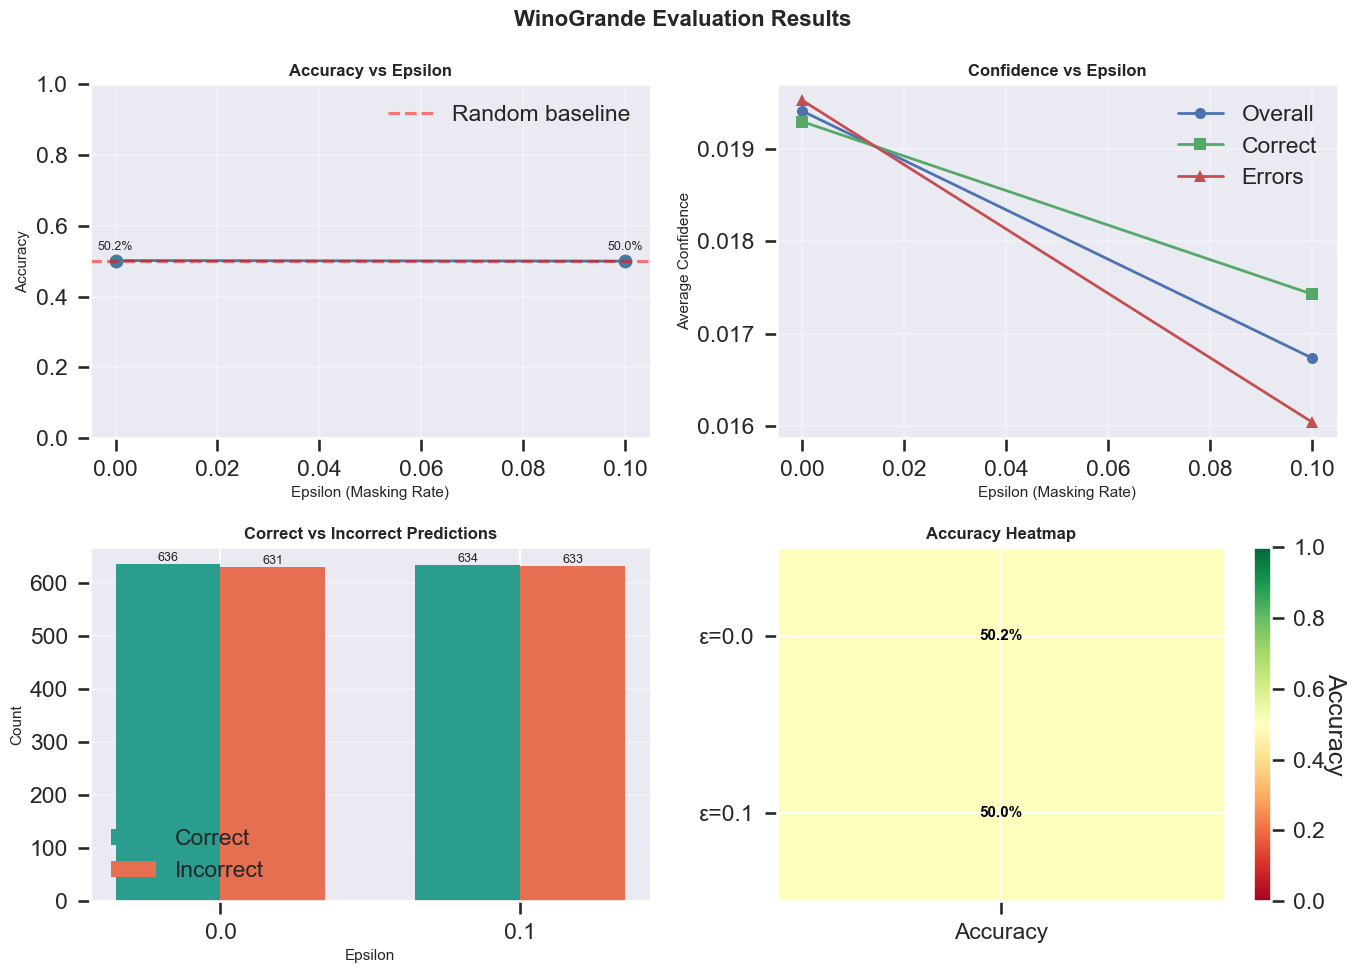


DETAILED SAMPLE ANALYSIS (Best Epsilon)

✓ CORRECT PREDICTIONS (636/1267):
--------------------------------------------------------------------------------

1. ID: winogrande_xs_0
   Text: Sarah was a much better surgeon than Maria so _ always got the easier cases....
   Question: Which option best completes the sentence?
   Options: ['Sarah', 'Maria']
   Predicted: Maria ✓
   Confidence: 0.0160

2. ID: winogrande_xs_2
   Text: They were worried the wine would ruin the bed and the blanket, but the _ was't ruined....
   Question: Which option best completes the sentence?
   Options: ['blanket', 'bed']
   Predicted: bed ✓
   Confidence: 0.0003

3. ID: winogrande_xs_3
   Text: Terry tried to bake the eggplant in the toaster oven but the _ was too big....
   Question: Which option best completes the sentence?
   Options: ['eggplant', 'toaster']
   Predicted: eggplant ✓
   Confidence: 0.0447

✗ INCORRECT PREDICTIONS (631/1267):
--------------------------------------------------------------

/var/folders/mn/7czszdld7kb157fq99zc_24c0000gr/T/ipykernel_74984/938995998.py:175: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_for_box, labels=labels_for_box, patch_artist=True,


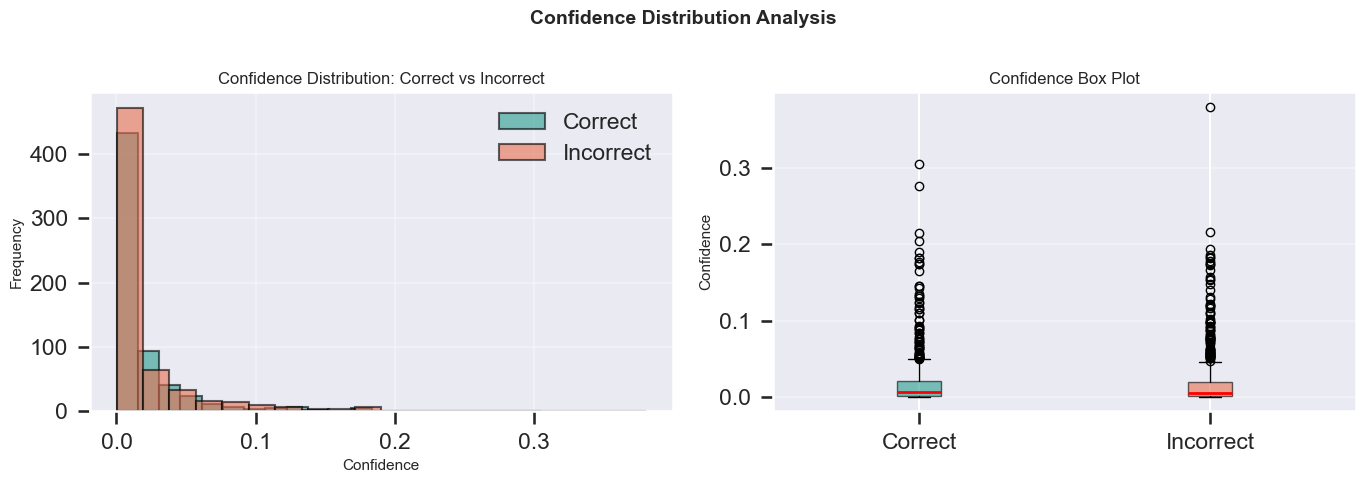


OPTION SCORE MARGIN ANALYSIS

Average score margin: 2.5818
Margin for correct predictions: 2.6287
Margin for incorrect predictions: 2.5344


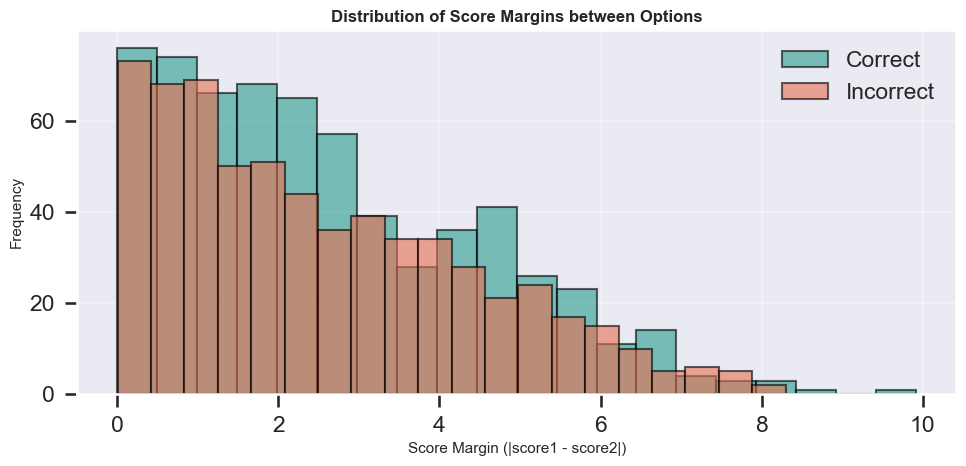


EVALUATION COMPLETE


In [41]:
# =====================================================================
# 1. SUMMARY STATISTICS TABLE
# =====================================================================
print("=" * 80)
print("WINOGRANDE EVALUATION SUMMARY")
print("=" * 80)
print(f"\nModel: {results['model']}")
print(f"Dataset: {results['dataset']}")
print(f"Total Samples: {results['summary']['num_samples']}")
print(f"\nBest Performance:")
print(f"  - Epsilon: {results['summary']['best_epsilon']}")
print(f"  - Accuracy: {results['summary']['best_accuracy']:.2%}")

# Performance by epsilon
print("\n" + "-" * 80)
print("PERFORMANCE BY EPSILON VALUE")
print("-" * 80)
epsilon_data = []
for eps in results['epsilon_values']:
    metrics = results['results_by_epsilon'][str(eps)]['metrics']
    epsilon_data.append({
        'Epsilon': eps,
        'Accuracy': f"{metrics['accuracy']:.2%}",
        'Correct': metrics['correct'],
        'Total': metrics['total'],
        'Avg Confidence': f"{metrics['avg_confidence']:.4f}",
        'Conf (Correct)': f"{metrics['avg_confidence_correct']:.4f}",
        'Conf (Errors)': f"{metrics['avg_confidence_errors']:.4f}"
    })

eps_df = pd.DataFrame(epsilon_data)
print(eps_df.to_string(index=False))

# =====================================================================
# 2. PERFORMANCE VISUALIZATION
# =====================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('WinoGrande Evaluation Results', fontsize=16, fontweight='bold')

# Plot 1: Accuracy vs Epsilon
eps_vals = results['epsilon_values']
accs = [results['results_by_epsilon'][str(e)]['metrics']['accuracy'] for e in eps_vals]
axes[0, 0].plot(eps_vals, accs, marker='o', linewidth=2, markersize=10, color='#457b9d')
axes[0, 0].set_xlabel('Epsilon (Masking Rate)', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Accuracy vs Epsilon', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random baseline')
for i, (e, a) in enumerate(zip(eps_vals, accs)):
    axes[0, 0].text(e, a + 0.03, f'{a:.1%}', ha='center', fontsize=9)
axes[0, 0].legend()

# Plot 2: Confidence vs Epsilon
avg_confs = [results['results_by_epsilon'][str(e)]['metrics']['avg_confidence'] for e in eps_vals]
conf_correct = [results['results_by_epsilon'][str(e)]['metrics']['avg_confidence_correct'] for e in eps_vals]
conf_errors = [results['results_by_epsilon'][str(e)]['metrics']['avg_confidence_errors'] for e in eps_vals]
axes[0, 1].plot(eps_vals, avg_confs, marker='o', label='Overall', linewidth=2, markersize=8)
axes[0, 1].plot(eps_vals, conf_correct, marker='s', label='Correct', linewidth=2, markersize=8)
axes[0, 1].plot(eps_vals, conf_errors, marker='^', label='Errors', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Epsilon (Masking Rate)', fontsize=11)
axes[0, 1].set_ylabel('Average Confidence', fontsize=11)
axes[0, 1].set_title('Confidence vs Epsilon', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Correct vs Incorrect counts
correct_counts = [results['results_by_epsilon'][str(e)]['metrics']['correct'] for e in eps_vals]
incorrect_counts = [results['results_by_epsilon'][str(e)]['metrics']['total'] - c for c in correct_counts]
x = np.arange(len(eps_vals))
width = 0.35
bars1 = axes[1, 0].bar(x - width/2, correct_counts, width, label='Correct', color='#2a9d8f')
bars2 = axes[1, 0].bar(x + width/2, incorrect_counts, width, label='Incorrect', color='#e76f51')
axes[1, 0].set_xlabel('Epsilon', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('Correct vs Incorrect Predictions', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([str(e) for e in eps_vals])
axes[1, 0].legend()
axes[1, 0].grid(True, axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Plot 4: Heatmap of accuracy by epsilon
heatmap_data = [[accs[i]] for i in range(len(eps_vals))]
im = axes[1, 1].imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[1, 1].set_yticks(range(len(eps_vals)))
axes[1, 1].set_yticklabels([f'ε={e}' for e in eps_vals])
axes[1, 1].set_xticks([0])
axes[1, 1].set_xticklabels(['Accuracy'])
axes[1, 1].set_title('Accuracy Heatmap', fontsize=12, fontweight='bold')
for i in range(len(eps_vals)):
    text = axes[1, 1].text(0, i, f'{accs[i]:.1%}',
                          ha="center", va="center", color="black", fontsize=11, fontweight='bold')
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('Accuracy', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# =====================================================================
# 3. DETAILED SAMPLE ANALYSIS
# =====================================================================
print("\n" + "=" * 80)
print("DETAILED SAMPLE ANALYSIS (Best Epsilon)")
print("=" * 80)

best_eps = results['summary']['best_epsilon']
detailed = results['results_by_epsilon'][str(best_eps)]['detailed']

# Show examples of correct predictions
correct_examples = [r for r in detailed if r['is_correct']]
incorrect_examples = [r for r in detailed if not r['is_correct']]

print(f"\n✓ CORRECT PREDICTIONS ({len(correct_examples)}/{len(detailed)}):")
print("-" * 80)
for i, ex in enumerate(correct_examples[:3], 1):  # Show first 3
    print(f"\n{i}. ID: {ex['schema_id']}")
    print(f"   Text: {ex['original_text'][:100]}...")
    print(f"   Question: {ex['question']}")
    print(f"   Options: {ex['options']}")
    print(f"   Predicted: {ex['predicted_answer']} ✓")
    print(f"   Confidence: {ex['confidence']:.4f}")

print(f"\n✗ INCORRECT PREDICTIONS ({len(incorrect_examples)}/{len(detailed)}):")
print("-" * 80)
for i, ex in enumerate(incorrect_examples[:3], 1):  # Show first 3
    print(f"\n{i}. ID: {ex['schema_id']}")
    print(f"   Text: {ex['original_text'][:100]}...")
    print(f"   Question: {ex['question']}")
    print(f"   Options: {ex['options']}")
    print(f"   Predicted: {ex['predicted_answer']} (Correct: {ex['correct_answer']}) ✗")
    print(f"   Confidence: {ex['confidence']:.4f}")
    scores_str = ", ".join([f"{opt}: {score:.3f}" for opt, score in zip(ex['options'], ex['option_scores'])])
    print(f"   Scores: {scores_str}")

# =====================================================================
# 4. CONFIDENCE DISTRIBUTION ANALYSIS
# =====================================================================
print("\n" + "=" * 80)
print("CONFIDENCE DISTRIBUTION ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Confidence Distribution Analysis', fontsize=14, fontweight='bold')

# Confidence distribution for correct vs incorrect
correct_confs = [r['confidence'] for r in detailed if r['is_correct']]
incorrect_confs = [r['confidence'] for r in detailed if not r['is_correct']]

if correct_confs:
    axes[0].hist(correct_confs, bins=20, alpha=0.6, label='Correct', color='#2a9d8f', edgecolor='black')
if incorrect_confs:
    axes[0].hist(incorrect_confs, bins=20, alpha=0.6, label='Incorrect', color='#e76f51', edgecolor='black')
axes[0].set_xlabel('Confidence', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Confidence Distribution: Correct vs Incorrect', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
data_for_box = []
labels_for_box = []
if correct_confs:
    data_for_box.append(correct_confs)
    labels_for_box.append('Correct')
if incorrect_confs:
    data_for_box.append(incorrect_confs)
    labels_for_box.append('Incorrect')

if data_for_box:
    bp = axes[1].boxplot(data_for_box, labels=labels_for_box, patch_artist=True,
                         medianprops=dict(color='red', linewidth=2))
    colors = ['#2a9d8f', '#e76f51']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[1].set_ylabel('Confidence', fontsize=11)
    axes[1].set_title('Confidence Box Plot', fontsize=12)
    axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# =====================================================================
# 5. OPTION SCORE ANALYSIS
# =====================================================================
print("\n" + "=" * 80)
print("OPTION SCORE MARGIN ANALYSIS")
print("=" * 80)

margins = []
for r in detailed:
    scores = r['option_scores']
    if len(scores) == 2:
        margin = abs(scores[0] - scores[1])
        margins.append({
            'id': r['schema_id'],
            'margin': margin,
            'correct': r['is_correct']
        })

margins_df = pd.DataFrame(margins)
if not margins_df.empty:
    print(f"\nAverage score margin: {margins_df['margin'].mean():.4f}")
    print(f"Margin for correct predictions: {margins_df[margins_df['correct']]['margin'].mean():.4f}")
    print(f"Margin for incorrect predictions: {margins_df[~margins_df['correct']]['margin'].mean():.4f}")
    
    fig, ax = plt.subplots(figsize=(10, 5))
    correct_margins = margins_df[margins_df['correct']]['margin']
    incorrect_margins = margins_df[~margins_df['correct']]['margin']
    
    if len(correct_margins) > 0:
        ax.hist(correct_margins, bins=20, alpha=0.6, label='Correct', color='#2a9d8f', edgecolor='black')
    if len(incorrect_margins) > 0:
        ax.hist(incorrect_margins, bins=20, alpha=0.6, label='Incorrect', color='#e76f51', edgecolor='black')
    
    ax.set_xlabel('Score Margin (|score1 - score2|)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Score Margins between Options', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)
print("EVALUATION COMPLETE")
print("=" * 80)


## 10. Research Question Analysis: Complete Workflow

This section demonstrates the complete workflow for testing our research hypothesis:
**"Do tasks with light knowledge demands and heavy reasoning demands benefit from epsilon masking?"**

The workflow includes:
1. Running multiple benchmarks with epsilon sweep
2. Aggregating results by task quadrant
3. Analyzing epsilon-performance correlations
4. Testing the hypothesis statistically
5. Generating comprehensive visualizations and reports


In [42]:
# ============================================================================
# COMPREHENSIVE RESEARCH WORKFLOW DEMO
# ============================================================================

print("="*80)
print("RESEARCH QUESTION ANALYSIS: KNOWLEDGE VS REASONING SEPARATION")
print("="*80)
print()

# Configuration
MODEL_NAME = "gpt2"
EPSILON_VALUES = [0.0, 0.1, 0.2, 0.3]
SEED = 42

# Initialize components
suite = BenchmarkSuite(benchmark_dir="src/evaluation/benchmarks")
quadrant_analyzer = QuadrantAnalyzer()
visualizer = ResultVisualizer()

print(f"Model: {MODEL_NAME}")
print(f"Epsilon values: {EPSILON_VALUES}")
print(f"Random seed: {SEED}")
print()

# ============================================================================
# STEP 1: Run Multiple Benchmarks
# ============================================================================
print("STEP 1: Running benchmarks across task quadrants...")
print("-"*80)

all_results = {}

# Winograd (Light Knowledge + Heavy Reasoning) - KEY HYPOTHESIS
print("\n[1/3] Running Winograd (Light Knowledge + Heavy Reasoning)...")
winograd_results = suite.run_winograd_benchmark(
    model_path=MODEL_NAME,
    epsilon_values=EPSILON_VALUES,
    dataset_name="winograd_dummy",
    seed=SEED
)
all_results["winograd_dummy"] = winograd_results
print(f"  ✓ Completed. Best accuracy: {winograd_results['summary']['best_accuracy']:.3f}")

# SQuAD (Heavy Knowledge + Medium Reasoning)
print("\n[2/3] Running SQuAD (Heavy Knowledge + Medium Reasoning)...")
squad_results = suite.run_squad_benchmark(
    model_path=MODEL_NAME,
    epsilon_values=EPSILON_VALUES,
    dataset_name="squad_dummy",
    seed=SEED,
    max_new_tokens=32
)
all_results["squad_dummy"] = squad_results
print(f"  ✓ Completed. Best F1: {squad_results['summary']['best_f1']:.3f}")

# GLUE tasks (Various quadrants)
print("\n[3/3] Running GLUE benchmarks (Multiple quadrants)...")
glue_results = suite.run_glue_benchmark(
    model_path=MODEL_NAME,
    tasks=["SST-2", "CoLA"],  # Light/Light and Light/Heavy
    epsilon_values=EPSILON_VALUES,
    seed=SEED
)

# Flatten GLUE results for analysis
for task, task_results in glue_results["per_task"].items():
    all_results[task.lower()] = {
        "benchmark": task.lower(),
        "dataset": task_results["dataset"],
        "model": MODEL_NAME,
        "epsilon_values": EPSILON_VALUES,
        "results_by_epsilon": task_results["results_by_epsilon"],
        "summary": task_results["summary"]
    }

print(f"  ✓ Completed. Macro avg accuracy: {glue_results['summary']['macro_avg_accuracy']:.3f}")

print("\n✓ All benchmarks completed!")
print(f"Total benchmarks run: {len(all_results)}")
print()


RESEARCH QUESTION ANALYSIS: KNOWLEDGE VS REASONING SEPARATION

Model: gpt2
Epsilon values: [0.0, 0.1, 0.2, 0.3]
Random seed: 42

STEP 1: Running benchmarks across task quadrants...
--------------------------------------------------------------------------------

[1/3] Running Winograd (Light Knowledge + Heavy Reasoning)...
  ✓ Completed. Best accuracy: 0.750

[2/3] Running SQuAD (Heavy Knowledge + Medium Reasoning)...


/Users/osadeh/Documents/Github/nlp-3523-final-project/.venv/lib/python3.12/site-packages/transformers/pytorch_utils.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)


  ✓ Completed. Best F1: 0.389

[3/3] Running GLUE benchmarks (Multiple quadrants)...
  ✓ Completed. Macro avg accuracy: 0.500

✓ All benchmarks completed!
Total benchmarks run: 4



In [43]:
# ============================================================================
# STEP 2: Aggregate Results by Quadrant
# ============================================================================
print("STEP 2: Aggregating results by task quadrant...")
print("-"*80)

quadrant_data = quadrant_analyzer.aggregate_by_quadrant(all_results)

print(f"\nQuadrants found: {len(quadrant_data)}")
for quadrant, eps_data in quadrant_data.items():
    knowledge, reasoning = quadrant
    quadrant_info = QUADRANT_DEFINITIONS.get(quadrant, {})
    name = quadrant_info.get("name", f"{knowledge}/{reasoning}")
    print(f"  - {name}: {len(eps_data)} epsilon values tested")

print()

# ============================================================================
# STEP 3: Analyze Epsilon-Performance Correlations
# ============================================================================
print("STEP 3: Analyzing epsilon-performance correlations...")
print("-"*80)

correlations = quadrant_analyzer.analyze_epsilon_correlation(quadrant_data)

print("\nCorrelation Analysis:")
print()
for quadrant, stats in sorted(correlations.items(), key=lambda x: x[1]["correlation"], reverse=True):
    knowledge, reasoning = quadrant
    quadrant_info = QUADRANT_DEFINITIONS.get(quadrant, {})
    name = quadrant_info.get("name", f"{knowledge}/{reasoning}")
    
    r = stats["correlation"]
    p = stats["p_value"]
    trend = stats["trend"]
    sig_marker = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    
    # Highlight hypothesis quadrant
    if quadrant == ("light", "heavy"):
        marker = "★ "
    else:
        marker = "  "
    
    print(f"{marker}{name:50s} r={r:6.3f} (p={p:.3f}) {sig_marker:3s} [{trend}]")

print()

# ============================================================================
# STEP 4: Test Research Hypothesis
# ============================================================================
print("STEP 4: Testing research hypothesis...")
print("-"*80)

hypothesis_test = quadrant_analyzer.test_hypothesis(correlations)

print("\n" + "="*80)
print("HYPOTHESIS TEST RESULTS")
print("="*80)
print()
print(f"Hypothesis: {hypothesis_test['hypothesis']}")
print()
print(f"Verdict: {hypothesis_test['verdict']}")
print(f"Confidence: {hypothesis_test['confidence']}")
print()
print(f"Target Quadrant: {hypothesis_test['target_quadrant']}")
print(f"  - Correlation: {hypothesis_test['target_correlation']:.3f}")
print(f"  - P-value: {hypothesis_test['target_p_value']:.3f}")
print(f"  - Is Positive: {hypothesis_test['is_positive']}")
print(f"  - Is Significant: {hypothesis_test['is_significant']}")
print()
print(f"Comparison to Other Quadrants:")
print(f"  - Average other correlation: {hypothesis_test['avg_other_correlation']:.3f}")
print(f"  - Target vs Others: {hypothesis_test['comparison']['target_vs_others']}")
if hypothesis_test['cohens_d'] is not None:
    print(f"  - Effect size (Cohen's d): {hypothesis_test['cohens_d']:.3f}")
print()
print("Interpretation:")
print(f"  {hypothesis_test['interpretation']}")
print()

# ============================================================================
# STEP 5: Display Comparison Table
# ============================================================================
print("STEP 5: Generating comparison table...")
print("-"*80)
print()

comparison_df = quadrant_analyzer.compare_quadrants(correlations)
print(comparison_df.to_string(index=False))
print()


STEP 2: Aggregating results by task quadrant...
--------------------------------------------------------------------------------

Quadrants found: 3
  - Light Knowledge + Heavy Reasoning: 4 epsilon values tested
  - Heavy Knowledge + Medium Reasoning: 4 epsilon values tested
  - Light Knowledge + Light Reasoning: 4 epsilon values tested

STEP 3: Analyzing epsilon-performance correlations...
--------------------------------------------------------------------------------

Correlation Analysis:

★ Light Knowledge + Heavy Reasoning                  r=-0.775 (p=0.225)     [not_significant]
  Heavy Knowledge + Medium Reasoning                 r=-0.785 (p=0.215)     [not_significant]
  Light Knowledge + Light Reasoning                  r=   nan (p=nan)     [not_significant]

STEP 4: Testing research hypothesis...
--------------------------------------------------------------------------------

HYPOTHESIS TEST RESULTS

Hypothesis: Light knowledge + heavy reasoning shows positive epsilon corre

/var/folders/mn/7czszdld7kb157fq99zc_24c0000gr/T/ipykernel_74984/2879530948.py:93: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = stats.pearsonr(epsilon_values, metric_values)


STEP 6: Generating visualizations...
--------------------------------------------------------------------------------

[1/3] Quadrant Comparison Grid...


/var/folders/mn/7czszdld7kb157fq99zc_24c0000gr/T/ipykernel_74984/4097562309.py:69: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/Users/osadeh/Documents/Github/nlp-3523-final-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


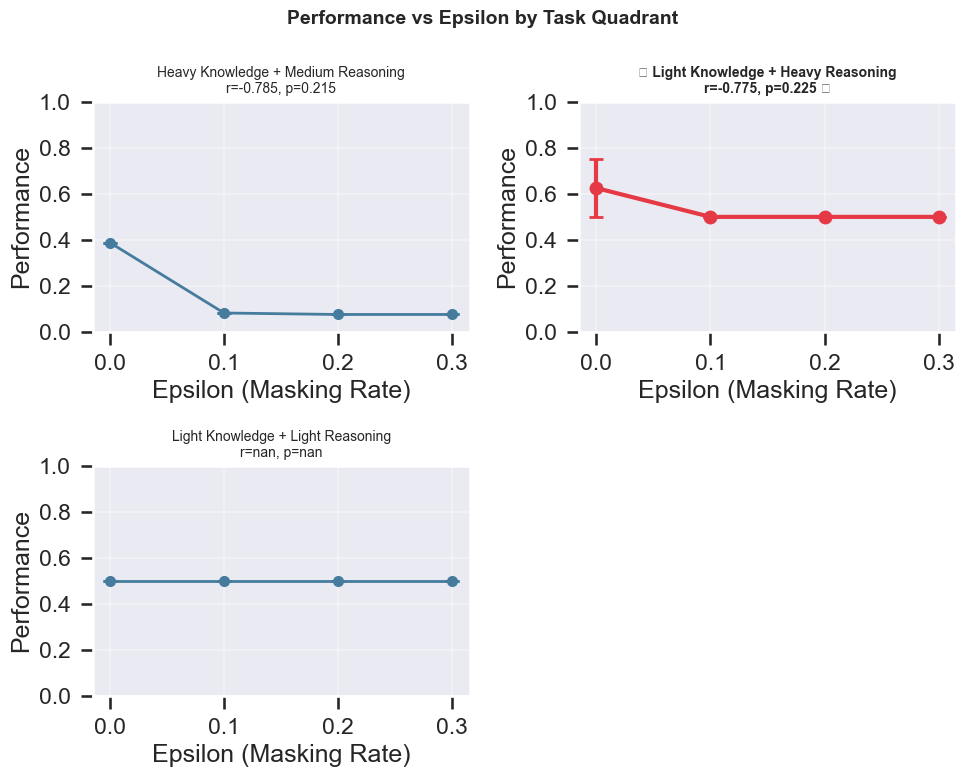

[2/3] Epsilon Sensitivity Comparison...


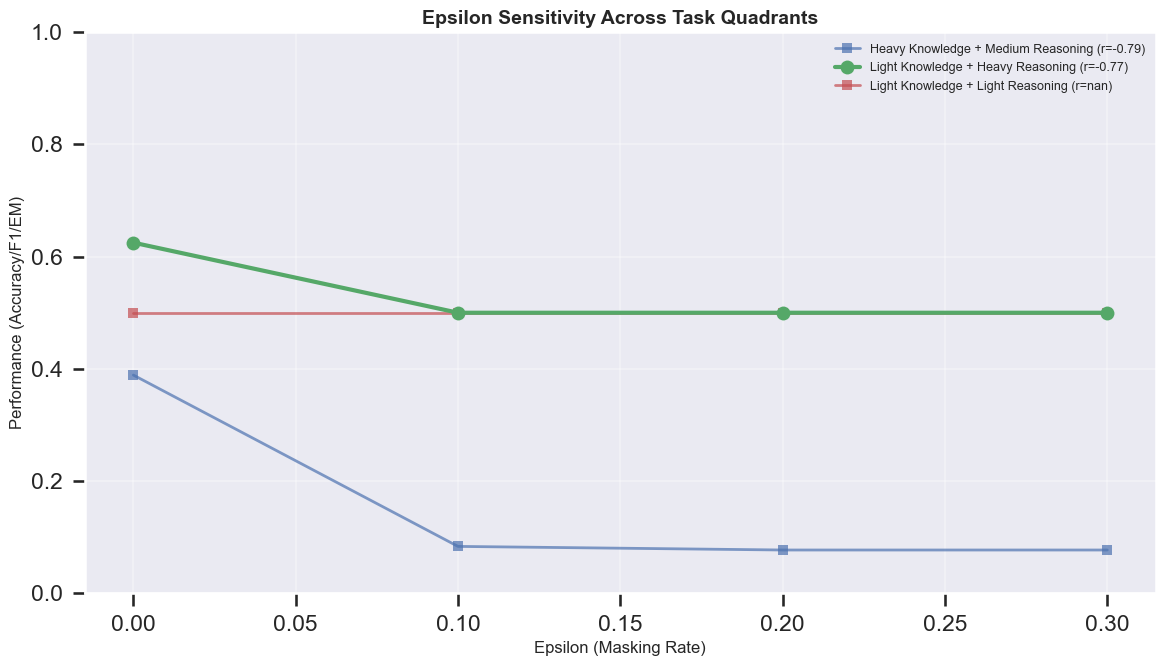

[3/3] Correlation Heatmap...


/var/folders/mn/7czszdld7kb157fq99zc_24c0000gr/T/ipykernel_74984/4097562309.py:200: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/Users/osadeh/Documents/Github/nlp-3523-final-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


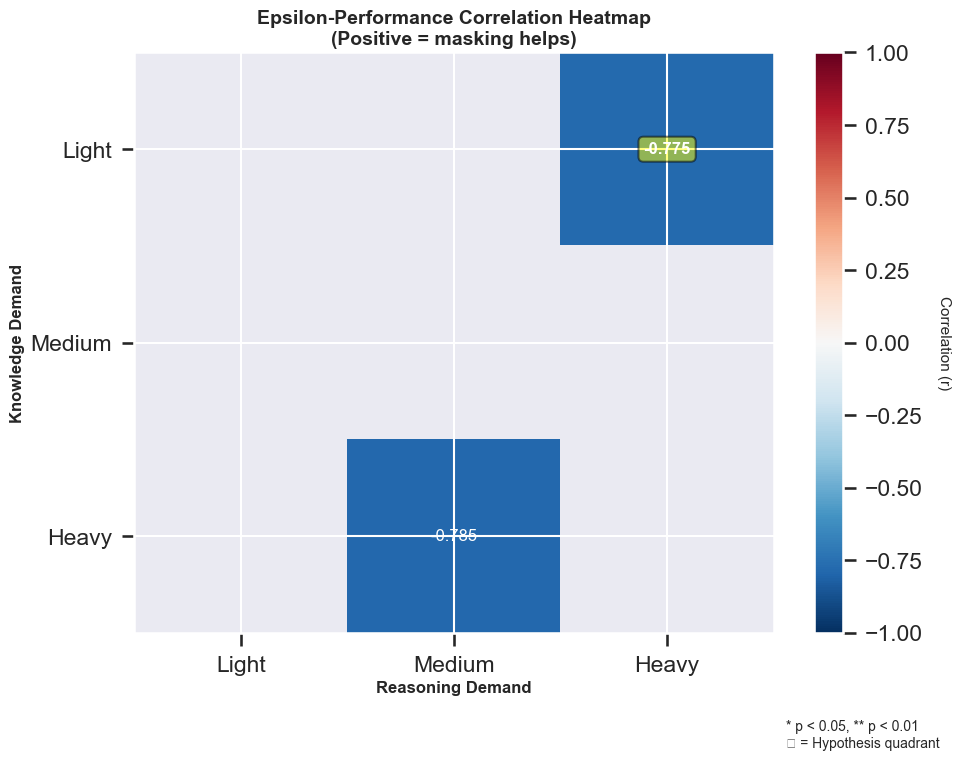


✓ All visualizations generated!

FINAL SUMMARY

Model Evaluated: gpt2
Benchmarks Tested: 4
Quadrants Analyzed: 3
Epsilon Range: 0.0 - 0.3

Key Findings:
  1. Hypothesis Verdict: NOT_SUPPORTED
  2. Target Quadrant Correlation: -0.775
  3. Statistical Significance: No
  4. Effect Size: small (d=0.000)

Next Steps for Full Research:
  1. Use larger, real datasets (full Winograd, SQuAD, GLUE)
  2. Test with multiple model sizes (GPT-2 small/medium/large)
  3. Expand epsilon range (0.0 to 0.8)
  4. Add more tasks per quadrant for statistical power
  5. Run multiple random seeds for robustness

ANALYSIS COMPLETE!


In [44]:
# ============================================================================
# STEP 6: Generate Visualizations
# ============================================================================
print("STEP 6: Generating visualizations...")
print("-"*80)
print()

# Visualization 1: Quadrant Comparison (2x2 grid)
print("[1/3] Quadrant Comparison Grid...")
fig1, axes1 = visualizer.plot_quadrant_comparison(quadrant_data, correlations)
plt.show()

# Visualization 2: Epsilon Sensitivity (all quadrants on one plot)
print("[2/3] Epsilon Sensitivity Comparison...")
fig2, ax2 = visualizer.plot_epsilon_sensitivity(quadrant_data, correlations)
plt.show()

# Visualization 3: Hypothesis Heatmap (knowledge x reasoning)
print("[3/3] Correlation Heatmap...")
fig3, ax3 = visualizer.plot_hypothesis_heatmap(correlations)
plt.show()

print("\n✓ All visualizations generated!")
print()

# ============================================================================
# STEP 7: Summary and Conclusion
# ============================================================================
print("="*80)
print("FINAL SUMMARY")
print("="*80)
print()

print(f"Model Evaluated: {MODEL_NAME}")
print(f"Benchmarks Tested: {len(all_results)}")
print(f"Quadrants Analyzed: {len(quadrant_data)}")
print(f"Epsilon Range: {min(EPSILON_VALUES)} - {max(EPSILON_VALUES)}")
print()

print("Key Findings:")
print(f"  1. Hypothesis Verdict: {hypothesis_test['verdict']}")
print(f"  2. Target Quadrant Correlation: {hypothesis_test['target_correlation']:.3f}")
print(f"  3. Statistical Significance: {'Yes' if hypothesis_test['is_significant'] else 'No'}")
if hypothesis_test['cohens_d'] is not None:
    effect_interpretation = "large" if abs(hypothesis_test['cohens_d']) > 0.8 else "medium" if abs(hypothesis_test['cohens_d']) > 0.5 else "small"
    print(f"  4. Effect Size: {effect_interpretation} (d={hypothesis_test['cohens_d']:.3f})")
print()

print("Next Steps for Full Research:")
print("  1. Use larger, real datasets (full Winograd, SQuAD, GLUE)")
print("  2. Test with multiple model sizes (GPT-2 small/medium/large)")
print("  3. Expand epsilon range (0.0 to 0.8)")
print("  4. Add more tasks per quadrant for statistical power")
print("  5. Run multiple random seeds for robustness")
print()

print("="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


### Quick Reference: Single-Function Analysis

For convenience, here's a single function that runs the entire analysis pipeline:


In [45]:
def run_complete_research_analysis(
    model_name: str = "gpt2",
    epsilon_values: List[float] = [0.0, 0.1, 0.2, 0.3],
    benchmark_tasks: List[str] = ["winograd_dummy", "squad_dummy", "sst-2", "cola"],
    seed: int = 42,
    visualize: bool = True,
    save_results: bool = False,
    output_dir: str = "results"
) -> Dict:
    """
    Run complete research analysis pipeline.
    
    Args:
        model_name: Hugging Face model name
        epsilon_values: List of masking rates to test
        benchmark_tasks: List of benchmark datasets to evaluate
        seed: Random seed for reproducibility
        visualize: Whether to generate visualizations
        save_results: Whether to save results to disk
        output_dir: Directory for saving results
        
    Returns:
        Complete analysis results including hypothesis test
    """
    print("Initializing complete research analysis pipeline...")
    
    # Initialize components
    suite = BenchmarkSuite()
    analyzer = QuadrantAnalyzer()
    viz = ResultVisualizer() if visualize else None
    
    # Run all benchmarks
    all_results = {}
    
    for task in benchmark_tasks:
        print(f"\nRunning {task}...")
        
        if "winograd" in task.lower():
            results = suite.run_winograd_benchmark(
                model_path=model_name,
                epsilon_values=epsilon_values,
                dataset_name=task,
                seed=seed
            )
        elif "squad" in task.lower():
            results = suite.run_squad_benchmark(
                model_path=model_name,
                epsilon_values=epsilon_values,
                dataset_name=task,
                seed=seed
            )
        else:
            # GLUE task
            glue_results = suite.run_glue_benchmark(
                model_path=model_name,
                tasks=[task.upper()],
                epsilon_values=epsilon_values,
                seed=seed
            )
            results = list(glue_results["per_task"].values())[0]
            results["benchmark"] = task
        
        all_results[task] = results
    
    # Generate full report
    report = analyzer.generate_full_report(all_results)
    
    # Print summary
    print("\n" + "="*80)
    print("HYPOTHESIS TEST RESULTS")
    print("="*80)
    hyp = report["hypothesis_test"]
    print(f"\nVerdict: {hyp['verdict']}")
    print(f"Confidence: {hyp['confidence']}")
    print(f"\n{hyp['interpretation']}")
    
    # Generate visualizations
    if visualize:
        print("\nGenerating visualizations...")
        viz.plot_quadrant_comparison(report["quadrant_data"], report["correlations"])
        plt.show()
        viz.plot_epsilon_sensitivity(report["quadrant_data"], report["correlations"])
        plt.show()
        viz.plot_hypothesis_heatmap(report["correlations"])
        plt.show()
    
    # Save results
    if save_results:
        from pathlib import Path
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        # Save comparison table
        report["comparison_table"].to_csv(output_path / "quadrant_comparison.csv", index=False)
        
        # Save full report (JSON serializable parts)
        import json
        with open(output_path / "full_report.json", "w") as f:
            json.dump({
                "model": model_name,
                "epsilon_values": epsilon_values,
                "hypothesis_test": hyp,
                "summary": report["summary"]
            }, f, indent=2)
        
        print(f"\n✓ Results saved to {output_dir}/")
    
    return report

# Example usage:
# report = run_complete_research_analysis(
#     model_name="gpt2",
#     epsilon_values=[0.0, 0.1, 0.2, 0.3, 0.5],
#     visualize=True,
#     save_results=True
# )

print("Convenience function 'run_complete_research_analysis' ready!")
print("Call it with your preferred settings to run the full pipeline.")


Convenience function 'run_complete_research_analysis' ready!
Call it with your preferred settings to run the full pipeline.
